# ClimateNet AR Analysis: ARTMIP comparisons

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl
from labellines import labelLine, labelLines

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
# 5 GB was fine for western US but ran into memory issues for western Europe (needed 20 GB)...due to extra rolling step to fix lons?
nmem1 = '5GiB' # PBSCluster specification
nmem2 = '5GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

<Client: 'tcp://128.117.208.99:42453' processes=0 threads=0, memory=0 B>

## Set ClimateNet filepath

In [29]:
cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

## Set regional bounds

In [30]:
# Selected transects along the North American West Coast (Rutz et al. 2019)
lat_bounds = slice(32,55)
lon_bounds = slice(230,245) # double check these lons

# Western Europe
#lat_bounds = slice(35,62) # Might even adjust down to 60N based on Fig. 4 of Rutz et al.
#lon_bounds = slice(-20,10) # Roll lons!
#lon_bounds = slice(345, 360) # visually it looks like Rutz et al. stops at 0E even though the NCL code uses 10E. In this case I wouldn't have to roll lons. Rutz et al. also mentions 15W as western boundary.

### Preprocessing function to subset regionally

In [31]:
def preprocess_region(ds):
    # return regional domain

    # rolling for western Europe slice crossing meridian
    #ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    #ds = ds.roll(lon=int(len(ds['lon']) / 2), roll_coords=True)
    
    return ds['masks'].sel(lat=lat_bounds,lon=lon_bounds)

## Read in landfrac for this CESM grid
To subset coastal points

In [32]:
landfrac_file = "/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/USGS-gtopo30_ne120np4_16xdel2-PFC-consistentSGH.regrid_0.23x0.31.nc"
landfrac_ds = xr.open_dataset(landfrac_file)

# rolling for western Europe slice
#landfrac_ds = landfrac_ds.assign_coords(lon=(((landfrac_ds.lon + 180) % 360) - 180))
#landfrac_ds = landfrac_ds.roll(lon=int(len(landfrac_ds['lon']) / 2), roll_coords=True)

landfrac = landfrac_ds.LANDFRAC.sel(lat=lat_bounds,lon=lon_bounds)

In [8]:
landfrac

<xarray.DataArray 'LANDFRAC' (lat: 98, lon: 49)> Size: 38kB
[4802 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 784B 32.03 32.27 32.5 32.74 ... 54.33 54.56 54.8
  * lon      (lon) float64 392B 230.0 230.3 230.6 230.9 ... 244.4 244.7 245.0
Attributes:
    long_name:      gridbox land fraction
    cell_measures:  area: area

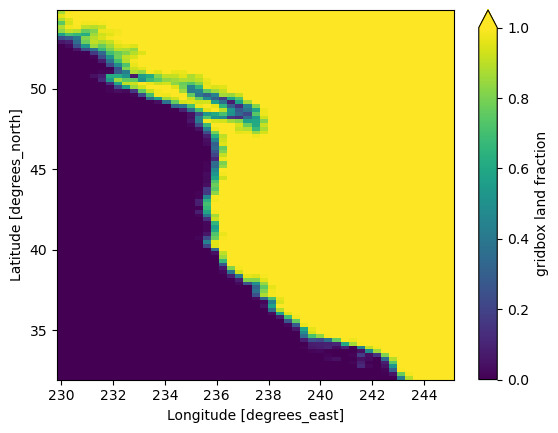

In [9]:
landfrac.plot(robust=True);

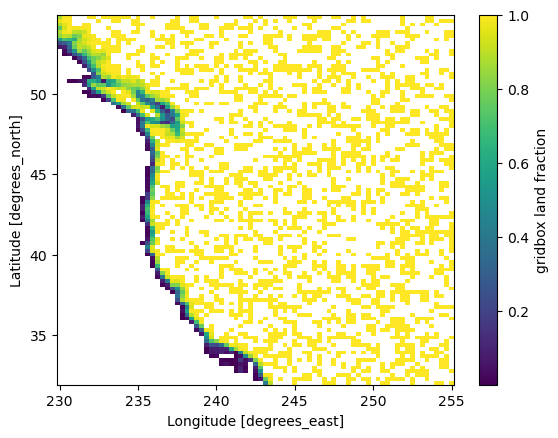

In [129]:
landfrac.where((landfrac > 0) & (landfrac < 1)).plot();

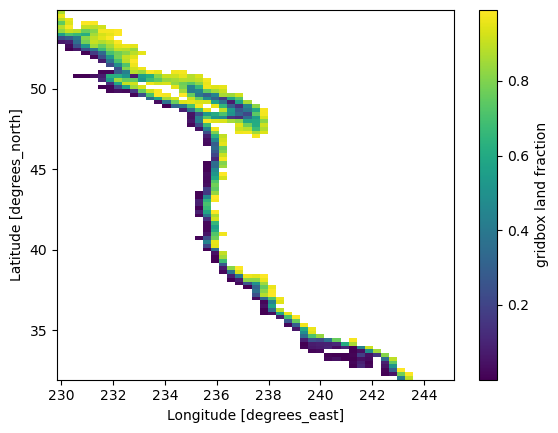

In [9]:
landfrac.where((landfrac > 0) & (landfrac < 0.99)).plot(); # use an upper bound of 0.99 to select the coastal points

## CESM historical simulation

In [33]:
hist_yrs = [str(i) for i in range(2000,2006)]
hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std

In [34]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
hist_paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)]
#hist_paths

### Read in masks with preprocessing

In [35]:
%%time
cnet_hist_shift = xr.open_mfdataset(hist_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 86 ms, sys: 6.91 ms, total: 92.9 ms
Wall time: 427 ms


In [13]:
cnet_hist_shift

<xarray.DataArray 'masks' (time: 17520, lat: 98, lon: 49)> Size: 673MB
dask.array<concatenate, shape=(17520, 98, 49), dtype=int64, chunksize=(500, 98, 49), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 392B 230.0 230.3 230.6 230.9 ... 244.4 244.7 245.0
  * lat      (lat) float64 784B 32.03 32.27 32.5 32.74 ... 54.33 54.56 54.8
  * time     (time) object 140kB 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

In [129]:
# OPTIONAL: persist for W Euro calcs with rolling lons (why does it add so much to the dask task graph?)
#cnet_hist_shift = cnet_hist_shift.persist() # could also persist after timeshift

### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [36]:
timeshift = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"h")
#timeshift

In [37]:
cnet_hist = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)
cnet_hist

<xarray.DataArray 'masks' (time: 17520, lat: 98, lon: 49)> Size: 673MB
dask.array<concatenate, shape=(17520, 98, 49), dtype=int64, chunksize=(500, 98, 49), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 392B 230.0 230.3 230.6 230.9 ... 244.4 244.7 245.0
  * lat      (lat) float64 784B 32.03 32.27 32.5 32.74 ... 54.33 54.56 54.8
  * time     (time) object 140kB 2000-01-01 00:00:00 ... 2005-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## CESM RCP2.6 simulation

In [38]:
#rcp26_yrs = [str(i) for i in range(2006,2016)]
rcp26_yrs = [str(i) for i in range(2006,2015)] # 15-year climatology
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # unweighted means/std

In [39]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp26_paths = [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
#rcp26_paths

### Read in masks with preprocessing

In [40]:
%%time
cnet_rcp26 = xr.open_mfdataset(rcp26_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 266 ms, sys: 2.27 ms, total: 268 ms
Wall time: 402 ms


In [20]:
cnet_rcp26

<xarray.DataArray 'masks' (time: 26280, lat: 98, lon: 49)> Size: 1GB
dask.array<concatenate, shape=(26280, 98, 49), dtype=int64, chunksize=(500, 98, 49), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 392B 230.0 230.3 230.6 230.9 ... 244.4 244.7 245.0
  * lat      (lat) float64 784B 32.03 32.27 32.5 32.74 ... 54.33 54.56 54.8
  * time     (time) object 210kB 2006-01-01 00:00:00 ... 2014-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    np:                         4
    ne:                         120
    case:                       b.e13.BRCP26C5CN.ne120_g16.003
    ...                         ...
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/p/cgd/amp/jet/mapfiles/map_ne120_to_dl...
    input_file:                 /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    history_of_appended_files:  Mon Apr  3 10:28:39 2023: Appended file 2006_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

In [134]:
# OPTIONAL: persist for W Euro calcs with rolling lons (why does it add so much to the dask task graph?)
#cnet_rcp26 = cnet_rcp26.persist()

## Combine historical/RCP2.6

In [41]:
cnet_hist_rcp26 = xr.concat([cnet_hist, cnet_rcp26], dim='time')
cnet_hist_rcp26

<xarray.DataArray 'masks' (time: 43800, lat: 98, lon: 49)> Size: 2GB
dask.array<concatenate, shape=(43800, 98, 49), dtype=int64, chunksize=(500, 98, 49), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 392B 230.0 230.3 230.6 230.9 ... 244.4 244.7 245.0
  * lat      (lat) float64 784B 32.03 32.27 32.5 32.74 ... 54.33 54.56 54.8
  * time     (time) object 350kB 2000-01-01 00:00:00 ... 2014-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Define ARs

In [42]:
AR = cnet_hist_rcp26.clip(min=1)-1
AR

<xarray.DataArray 'masks' (time: 43800, lat: 98, lon: 49)> Size: 2GB
dask.array<sub, shape=(43800, 98, 49), dtype=int64, chunksize=(500, 98, 49), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 392B 230.0 230.3 230.6 230.9 ... 244.4 244.7 245.0
  * lat      (lat) float64 784B 32.03 32.27 32.5 32.74 ... 54.33 54.56 54.8
  * time     (time) object 350kB 2000-01-01 00:00:00 ... 2014-12-31 21:00:00

### Persist to make the following calcs faster

In [43]:
AR = AR.persist()

### Counts at coastline
Using `artmip_countsbylat_xy.env.ncl` and `plot_artmip_countsbylat_newmethod_xy.ncl` from C. Shields as a starting point

#### ARcount over time at each gridpoint

In [24]:
ARcount = AR.sum(dim='time')
#ARcount.plot();

#### Select for fractional land/sea points

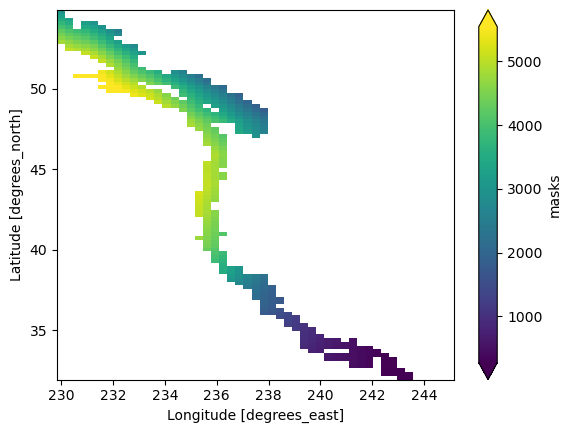

In [25]:
#ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 1)) 
ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 0.99)) # upper bound chosen to account for weird behavior in landfrac max when using upper bound < 1
ARcount_frac.plot(robust=True);

In [26]:
ARcount_frac

<xarray.DataArray 'masks' (lat: 98, lon: 49)> Size: 38kB
dask.array<where, shape=(98, 49), dtype=float64, chunksize=(98, 49), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 392B 230.0 230.3 230.6 230.9 ... 244.4 244.7 245.0
  * lat      (lat) float64 784B 32.03 32.27 32.5 32.74 ... 54.33 54.56 54.8

#### Debugging - check individual plots

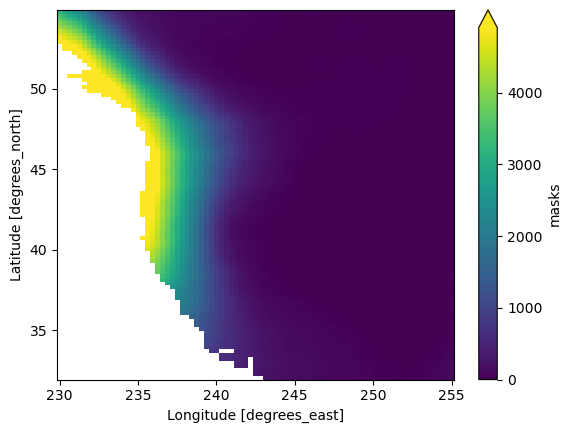

In [49]:
ARcount.where(landfrac > 0).plot(robust=True);

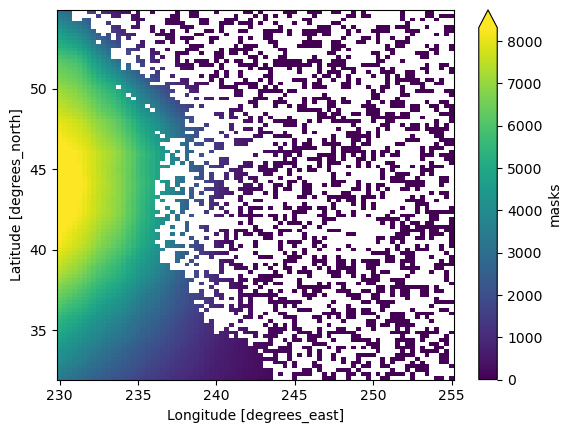

In [50]:
ARcount.where(landfrac < 1).plot(robust=True);

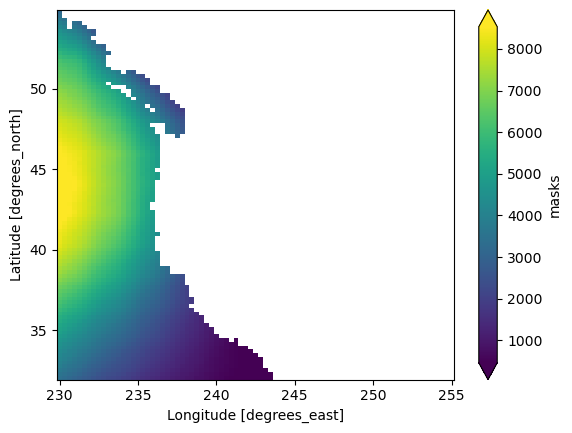

In [51]:
# it's a weird rounding thing!! something with interpreting landfrac
ARcount.where(landfrac < 0.99).plot(robust=True);

#### Average across longitudes at each latitude
Why not sum / total time points for frequency?\
There aren't that many longitudes included once you select for fractional land/sea points

In [27]:
ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
#ARcount_frac_zmean.plot();

#### Frequency calculation

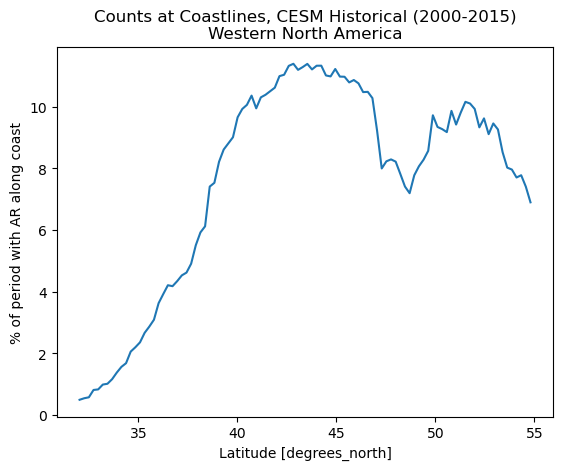

In [28]:
ARfreq_frac_zmean = 100*(ARcount_frac_zmean / len(AR.time))
ARfreq_frac_zmean.plot()
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, CESM Historical (2000-2015)\nWestern North America');
#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_hist_rcp26.png');

#plt.title('Counts at Coastlines, CESM Historical (2000-2015)\nWestern Europe')
#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WEuro_CESM_hist_rcp26.png');

#### Testing - try the total at each latitude instead of the average

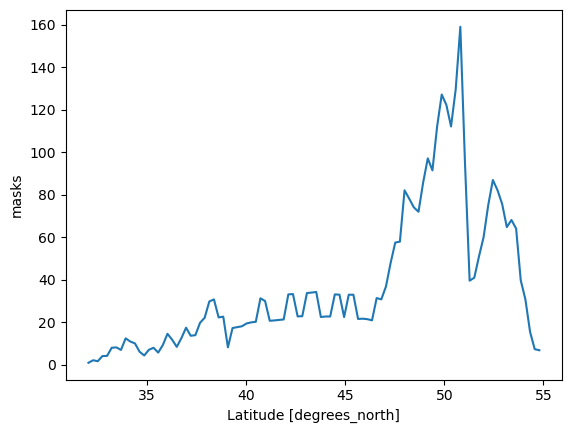

In [24]:
(100 * (ARcount_frac.sum(dim='lon', skipna=True) / len(AR.time))).plot();

### Function for easier use

In [44]:
def counts_at_coastlines(AR, landfrac):
    ARcount = AR.sum(dim='time')
    ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 0.99))
    ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
    ARfreq_frac_zmean = 100*(ARcount_frac_zmean / len(AR.time))
    return(ARfreq_frac_zmean)

In [45]:
ARfreq_frac_zmean = counts_at_coastlines(AR, landfrac)

### Seasonal counts

In [46]:
def counts_at_coastlines_season(AR, landfrac):
    ARcount = AR.groupby('time.season').sum(dim='time')
    ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 0.99))
    ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
    ARfreq_frac_zmean = 100*(ARcount_frac_zmean / AR.time.groupby('time.season').count())
    return(ARfreq_frac_zmean)

In [47]:
ARfreq_frac_zmean_season = counts_at_coastlines_season(AR, landfrac)
ARfreq_frac_zmean_season

<xarray.DataArray (season: 4, lat: 98)> Size: 3kB
dask.array<mul, shape=(4, 98), dtype=float64, chunksize=(1, 98), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 784B 32.03 32.27 32.5 32.74 ... 54.33 54.56 54.8
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'

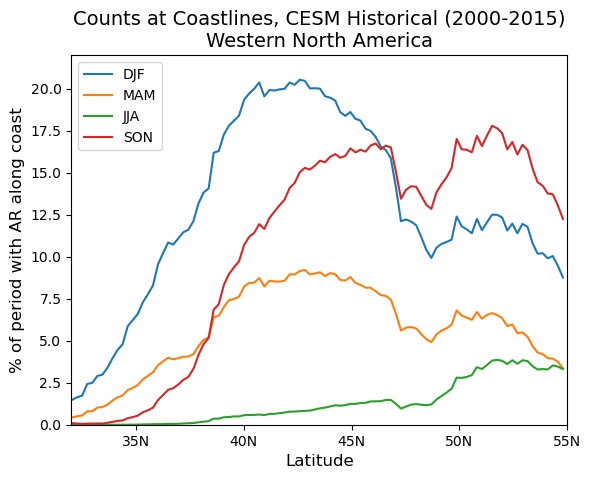

In [48]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']
for i,s in enumerate(seasons):
    ARfreq_frac_zmean_season.sel(season=s).plot(label=s)
plt.legend()
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('% of period with AR along coast', fontsize=12)

plt.xlim(32,55)
plt.xticks([35, 40, 45, 50, 55], ['35N', '40N', '45N', '50N', '55N'])

plt.ylim(0,22)

plt.title('Counts at Coastlines, CESM Historical (2000-2015)\nWestern North America', fontsize=14);

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_season_WUS_CESM_hist.png')

## CESM RCP8.5 simulation

In [49]:
rcp85_yrs = [str(i) for i in range(2086,2101)]
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks_unwgt/" for y in rcp85_yrs] # unweighted means/std
rcp85_folders = ["BRCP85C5CN/"+y+"/masks_rcp85config/" for y in rcp85_yrs] # RCP8.5 data used to calculate means/std in config file (unweighted)

In [50]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp85_paths = [cesm_cnet_filepath+rcp85_folders[i]+cnet_file for i,f in enumerate(rcp85_folders)]

### Read in masks with preprocessing

In [51]:
%%time
cnet_rcp85 = xr.open_mfdataset(rcp85_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 159 ms, sys: 8.58 ms, total: 168 ms
Wall time: 486 ms


In [34]:
cnet_rcp85

<xarray.DataArray 'masks' (time: 43800, lat: 98, lon: 49)> Size: 2GB
dask.array<concatenate, shape=(43800, 98, 49), dtype=int64, chunksize=(500, 98, 49), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 784B 32.03 32.27 32.5 32.74 ... 54.33 54.56 54.8
  * lon      (lon) float64 392B 230.0 230.3 230.6 230.9 ... 244.4 244.7 245.0
  * time     (time) object 350kB 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    remap_script:               ncremap
    remap_version:              4.7.9
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    history_of_appended_files:  Mon Apr  3 13:13:47 2023: Appended file outpu...

In [52]:
AR_rcp85 = cnet_rcp85.clip(min=1)-1

In [53]:
AR_rcp85 = AR_rcp85.persist()

In [54]:
ARfreq_frac_zmean_rcp85 = counts_at_coastlines(AR_rcp85, landfrac)
ARfreq_frac_zmean_rcp85

<xarray.DataArray 'masks' (lat: 98)> Size: 784B
dask.array<mul, shape=(98,), dtype=float64, chunksize=(98,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 784B 32.03 32.27 32.5 32.74 ... 54.33 54.56 54.8

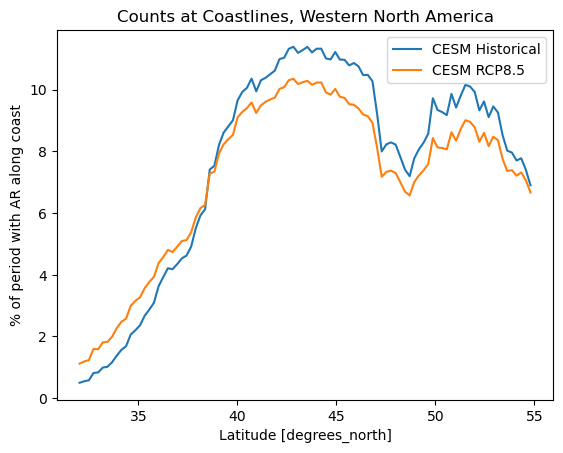

In [38]:
ARfreq_frac_zmean.plot(label='CESM Historical')
ARfreq_frac_zmean_rcp85.plot(label='CESM RCP8.5')

plt.legend()

plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, Western North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_hist_rcp26_rcp85.png');

In [55]:
ARfreq_frac_zmean_rcp85_season = counts_at_coastlines_season(AR_rcp85, landfrac)

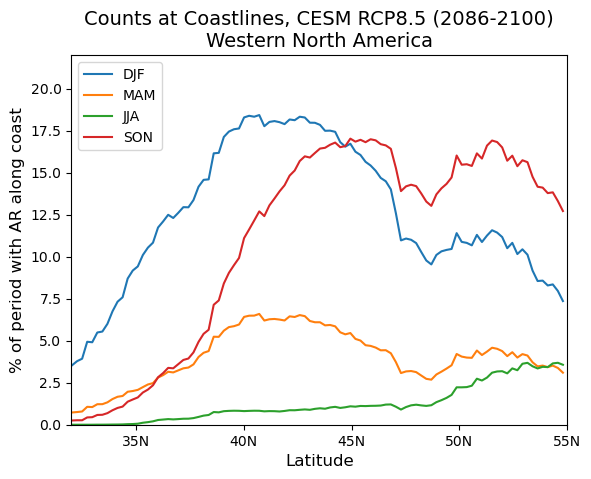

In [32]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']
for i,s in enumerate(seasons):
    ARfreq_frac_zmean_rcp85_season.sel(season=s).plot(label=s)
plt.legend()
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('% of period with AR along coast', fontsize=12)

plt.xlim(32,55)
plt.xticks([35, 40, 45, 50, 55], ['35N', '40N', '45N', '50N', '55N'])

plt.ylim(0,22)

plt.title('Counts at Coastlines, CESM RCP8.5 (2086-2100)\nWestern North America', fontsize=14);

## MERRA2

In [56]:
merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier1/ClimateNet_DL/' # tier1, 3hrly
merra_cnet_path_t2 = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier2/MERRA2_native/climatenet/' # tier2, 1hrly

In [57]:
file_years = '*.20[00-15]*' # not a perfect wildcard, but captures 2000 - 2017 (or 2019 for tier2)
#file_years = '*.nc4' # for all years; 1980 - June 2017

### Preprocessing function to subset regionally

In [58]:
# CESM bounds
#lat_bounds = slice(32,55)
#lon_bounds = slice(230,245) # double check these lons

# MERRA2 lons are -180 / +180
lat_bounds_merra = slice(32,55)
lon_bounds_merra = slice(-130,-115)

In [59]:
def preprocess_region_merra(ds):
    # return regional domain
    return ds['ar_binary_tag'].sel(lat=lat_bounds_merra,lon=lon_bounds_merra)

### Read in data

In [60]:
%%time
merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region_merra)

CPU times: user 86.7 ms, sys: 0 ns, total: 86.7 ms
Wall time: 285 ms


In [61]:
merra_cnet_t2 = xr.open_mfdataset(merra_cnet_path_t2+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region_merra)
merra_cnet_t2

<xarray.DataArray 'ar_binary_tag' (time: 175320, lat: 47, lon: 25)> Size: 206MB
dask.array<concatenate, shape=(175320, 47, 25), dtype=int8, chunksize=(500, 47, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0
  * lon      (lon) float32 100B -130.0 -129.4 -128.8 ... -116.2 -115.6 -115.0
  * time     (time) datetime64[ns] 1MB 2000-01-01T00:30:00 ... 2019-12-31T23:...
Attributes:
    description:  binary indicator of atmospheric river
    scheme:       ClimateNet_DL_model
    version:      CGNet

In [62]:
# subset 2000-2015 to match CESM years (number of time indices will not match due to CESM shifted start and MERRA leap years)
#merra_ar = merra_ar_full.sel(time=slice("2000","2015"))
merra_ar = merra_cnet.sel(time=slice("2000","2014")) # 15-year climatology
merra_ar_t2 = merra_cnet_t2.sel(time=slice("2000","2014"))

In [63]:
merra_ar = merra_ar.persist()

In [64]:
merra_ar_t2 = merra_ar_t2.persist()

### Read in MERRA2 landfrac
Actually stored as 'ocnfrac'\
CGD machines: /project/ccr/shields/merra2/merra2_ocn_land_fraction.nc\
CISL machines: /glade/derecho/scratch/shields/ARTMIP/grids/merra2_ocn_land_fraction.nc 

In [65]:
merra_landfrac_file = "/glade/derecho/scratch/shields/ARTMIP/grids/merra2_ocn_land_fraction.nc"
merra_landfrac_ds = xr.open_dataset(merra_landfrac_file)
#merra_landfrac_ds

In [66]:
merra_landfrac = 1-(merra_landfrac_ds.ocnfrac.sel(lat=lat_bounds_merra,lon=lon_bounds_merra))
#merra_landfrac

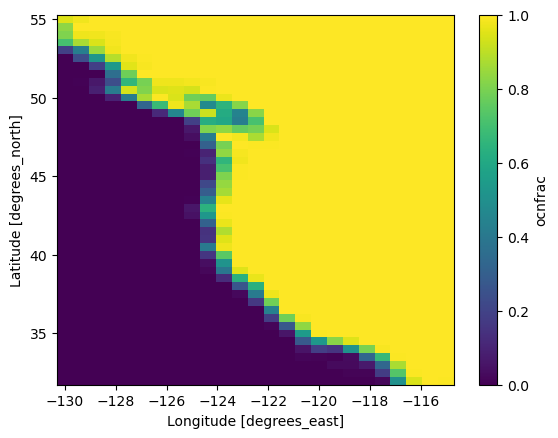

In [52]:
merra_landfrac.plot();

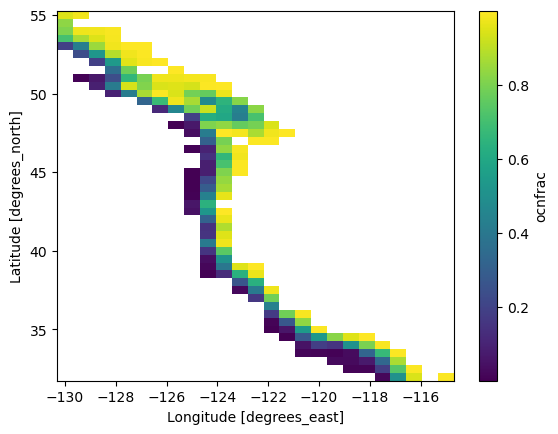

In [55]:
merra_landfrac.where((merra_landfrac > 0) & (merra_landfrac < 1)).plot(); # no need to mess with bounds here
#merra_landfrac.where((merra_landfrac > 0) & (merra_landfrac < 0.99)).plot(); # check for using the same function

In [67]:
def counts_at_coastlines_merra(AR, landfrac):
    ARcount = AR.sum(dim='time')
    ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 1)) # change the bound for merra calculation
    ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
    ARfreq_frac_zmean = 100*(ARcount_frac_zmean / len(AR.time))
    return(ARfreq_frac_zmean)

In [68]:
ARfreq_frac_zmean_merra = counts_at_coastlines_merra(merra_ar, merra_landfrac)
ARfreq_frac_zmean_merra

<xarray.DataArray 'ar_binary_tag' (lat: 47)> Size: 376B
dask.array<mul, shape=(47,), dtype=float64, chunksize=(47,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0

In [69]:
ARfreq_frac_zmean_merra_t2 = counts_at_coastlines_merra(merra_ar_t2, merra_landfrac)
ARfreq_frac_zmean_merra_t2

<xarray.DataArray 'ar_binary_tag' (lat: 47)> Size: 376B
dask.array<mul, shape=(47,), dtype=float64, chunksize=(47,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0

In [70]:
def counts_at_coastlines_merra_season(AR, landfrac):
    ARcount = AR.groupby('time.season').sum(dim='time')
    ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 1)) # change the bound for merra calculation
    ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
    ARfreq_frac_zmean = 100*(ARcount_frac_zmean / AR.time.groupby('time.season').count())
    return(ARfreq_frac_zmean)

In [71]:
ARfreq_frac_zmean_merra_season = counts_at_coastlines_merra_season(merra_ar, merra_landfrac)
ARfreq_frac_zmean_merra_season

<xarray.DataArray (season: 4, lat: 47)> Size: 2kB
dask.array<mul, shape=(4, 47), dtype=float64, chunksize=(1, 47), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'

In [72]:
ARfreq_frac_zmean_merra_t2_season = counts_at_coastlines_merra_season(merra_ar_t2, merra_landfrac)
ARfreq_frac_zmean_merra_t2_season

<xarray.DataArray (season: 4, lat: 47)> Size: 2kB
dask.array<mul, shape=(4, 47), dtype=float64, chunksize=(1, 47), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'

## Compare CESM and MERRA

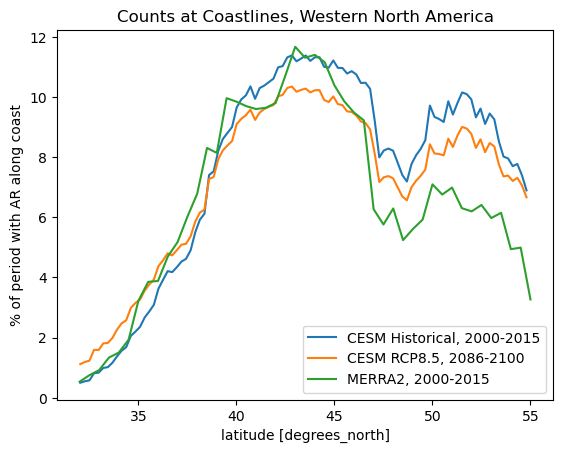

In [58]:
ARfreq_frac_zmean.plot(label='CESM Historical, 2000-2015')
ARfreq_frac_zmean_rcp85.plot(label='CESM RCP8.5, 2086-2100')
ARfreq_frac_zmean_merra.plot(label='MERRA2, 2000-2015')

plt.legend()

plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, Western North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_hist_rcp26_rcp85_merra.png', dpi=300);

No need to scale the MERRA Tier 2 results even though it is 1-hourly, the % calculation accounts for this

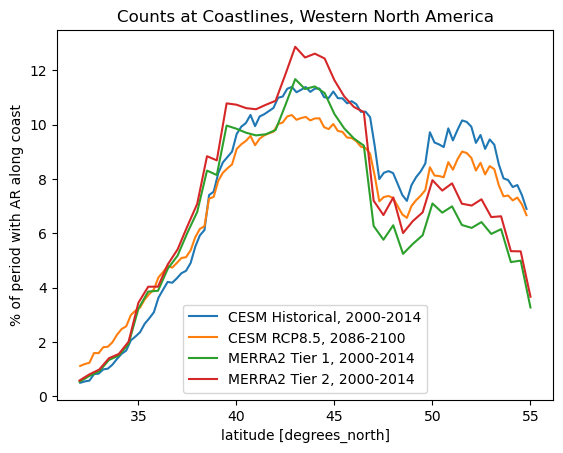

In [62]:
ARfreq_frac_zmean.plot(label='CESM Historical, 2000-2014')
ARfreq_frac_zmean_rcp85.plot(label='CESM RCP8.5, 2086-2100')
ARfreq_frac_zmean_merra.plot(label='MERRA2 Tier 1, 2000-2014')
ARfreq_frac_zmean_merra_t2.plot(label='MERRA2 Tier 2, 2000-2014')

plt.legend()

plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, Western North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_hist_rcp26_rcp85_merra.png', dpi=300);

## ERA5

In [4]:
era_cnet_path = '/glade/campaign/collections/rda/data/d651018/catalogues/ERA5/climatenet/' # tier2, 1hrly, 0.25deg

In [5]:
#era_file_years = '*.20[00-15]*' # can't figure out how to subset more than 2000-2019 which is the entire dataset anyway
era_file_years = '*.nc'

### Preprocessing function to (optionally) subset regionally

In [9]:
# CESM bounds
#lat_bounds = slice(32,55)
lon_bounds = slice(230,245) # double check these lons

# ERA5 lats are reverse ordered?
# ERA5 lons are 0, 360 like CESM
lat_bounds_era = slice(55, 32)

In [10]:
def preprocess_region_era(ds):
    # return regional domain
    return ds['ar_binary_tag'].sel(lat=lat_bounds_era,lon=lon_bounds)

### Read in data

In [11]:
era_cnet = xr.open_mfdataset(era_cnet_path+era_file_years, concat_dim='time', combine='nested', chunks={'time':5000}, parallel=True, preprocess=preprocess_region_era)
era_cnet

<xarray.DataArray 'ar_binary_tag' (time: 175320, lat: 93, lon: 61)> Size: 995MB
dask.array<concatenate, shape=(175320, 93, 61), dtype=int8, chunksize=(5000, 93, 61), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 372B 55.0 54.75 54.5 54.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 244B 230.0 230.2 230.5 230.8 ... 244.5 244.8 245.0
  * time     (time) datetime64[ns] 1MB 2000-01-01 ... 2019-12-31T23:00:00
Attributes:
    description:  binary indicator of atmospheric river
    scheme:       ClimateNet_DL_model
    version:      CGNet

In [12]:
# subset 2000-2014 to match CESM years (number of time indices will not match due to CESM shifted start and ERA leap years)
era_ar = era_cnet.sel(time=slice("2000","2014"))
era_ar

<xarray.DataArray 'ar_binary_tag' (time: 131496, lat: 93, lon: 61)> Size: 746MB
dask.array<getitem, shape=(131496, 93, 61), dtype=int8, chunksize=(5000, 93, 61), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 372B 55.0 54.75 54.5 54.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 244B 230.0 230.2 230.5 230.8 ... 244.5 244.8 245.0
  * time     (time) datetime64[ns] 1MB 2000-01-01 ... 2014-12-31T23:00:00
Attributes:
    description:  binary indicator of atmospheric river
    scheme:       ClimateNet_DL_model
    version:      CGNet

In [13]:
era_ar = era_ar.persist()

### Read in ERA5 landfrac
Stored as 'lsm'\
CISL machines: /glade/derecho/scratch/shields/ARTMIP/grids/ERA5_landseamask.nc 

In [14]:
era_landfrac_file = "/glade/derecho/scratch/shields/ARTMIP/grids/ERA5_landseamask.nc"
era_landfrac_ds = xr.open_dataset(era_landfrac_file)
era_landfrac_ds

<xarray.Dataset> Size: 8MB
Dimensions:    (longitude: 1440, latitude: 721, time: 1)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 8B 1980-01-01
Data variables:
    lsm        (time, latitude, longitude) float64 8MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-21 11:14:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [15]:
era_landfrac = era_landfrac_ds.lsm.sel(latitude=lat_bounds_era,longitude=lon_bounds).squeeze() # remove single time dimension
era_landfrac

<xarray.DataArray 'lsm' (latitude: 93, longitude: 61)> Size: 45kB
[5673 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 244B 230.0 230.2 230.5 ... 244.5 244.8 245.0
  * latitude   (latitude) float32 372B 55.0 54.75 54.5 54.25 ... 32.5 32.25 32.0
    time       datetime64[ns] 8B 1980-01-01
Attributes:
    units:          (0 - 1)
    long_name:      Land-sea mask
    standard_name:  land_binary_mask

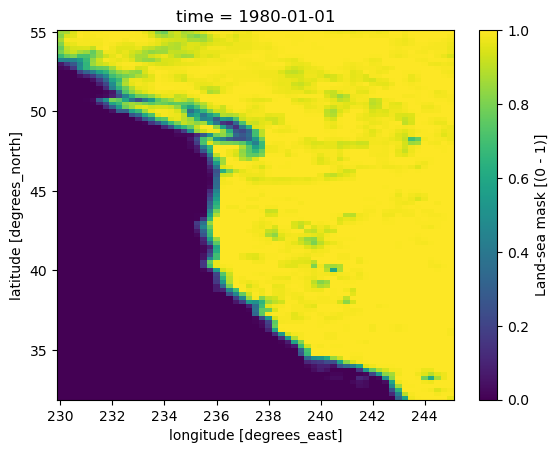

In [16]:
era_landfrac.plot();

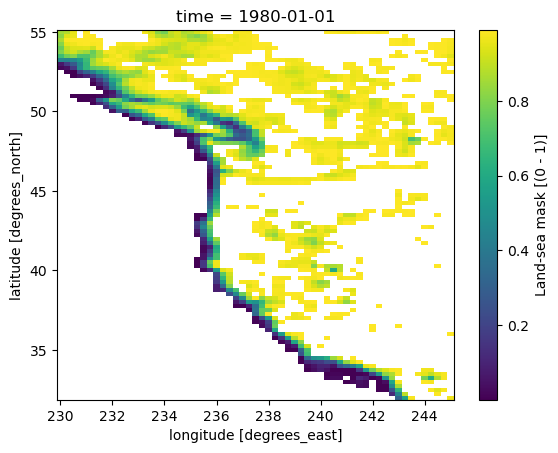

In [17]:
era_landfrac.where((era_landfrac > 0) & (era_landfrac < 0.99)).plot(); # check for using the same function - doesn't quite work, must include lakes?

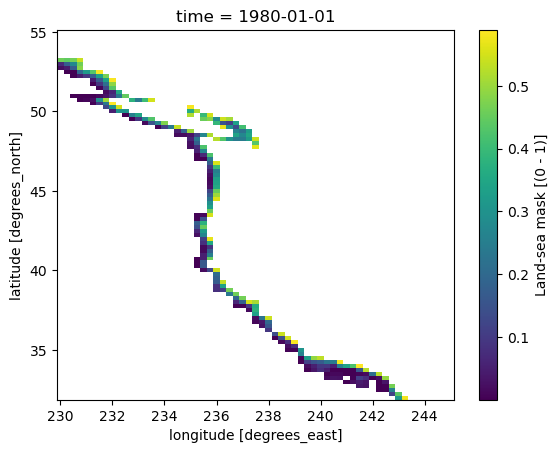

In [18]:
era_landfrac.where((era_landfrac > 0) & (era_landfrac < 0.59)).plot(); # need to decrease the upper bound to eliminate the inlandlakes
# however when I do this I'm cutting off the high latitudes of this plot, which I guess is ok because its not really coastline at that point (would need to extend longitude boundary west)

In [19]:
# rename coordinates to match ARs
era_landfrac = era_landfrac.rename({'longitude': 'lon','latitude': 'lat'})

In [ ]:
# what if we use the CESM landfrac for selecting the ERA landfrac points? The grids aren't quite the same...
#era_landfrac.where((landfrac > 0) & (landfrac < 0.99)).plot();

### New function with ERA landfrac bounds

In [20]:
def counts_at_coastlines_era(AR, landfrac):
    ARcount = AR.sum(dim='time')
    ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 0.59))
    ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
    ARfreq_frac_zmean = 100*(ARcount_frac_zmean / (len(AR.time)))
    return(ARfreq_frac_zmean)

In [21]:
ARfreq_frac_zmean_era = counts_at_coastlines_era(era_ar, era_landfrac)
ARfreq_frac_zmean_era

<xarray.DataArray 'ar_binary_tag' (lat: 93)> Size: 744B
dask.array<mul, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 372B 55.0 54.75 54.5 54.25 ... 32.75 32.5 32.25 32.0
    time     datetime64[ns] 8B 1980-01-01

In [22]:
def counts_at_coastlines_era_season(AR, landfrac):
    ARcount = AR.groupby('time.season').sum(dim='time')
    ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 0.59))
    ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
    ARfreq_frac_zmean = 100*(ARcount_frac_zmean / AR.time.groupby('time.season').count())
    return(ARfreq_frac_zmean)

In [23]:
ARfreq_frac_zmean_era_season = counts_at_coastlines_era_season(era_ar, era_landfrac)
ARfreq_frac_zmean_era_season

<xarray.DataArray (season: 4, lat: 93)> Size: 3kB
dask.array<mul, shape=(4, 93), dtype=float64, chunksize=(1, 93), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 372B 55.0 54.75 54.5 54.25 ... 32.75 32.5 32.25 32.0
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
    time     datetime64[ns] 8B 1980-01-01

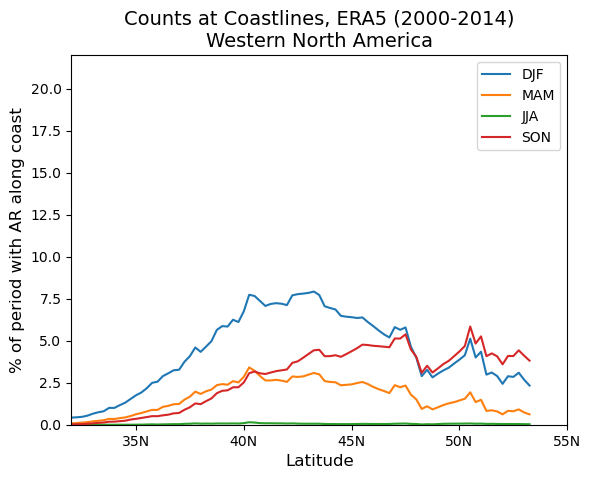

In [110]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']
for i,s in enumerate(seasons):
    ARfreq_frac_zmean_era_season.sel(season=s).plot(label=s)
plt.legend()
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('% of period with AR along coast', fontsize=12)

plt.xlim(32,55)
plt.xticks([35, 40, 45, 50, 55], ['35N', '40N', '45N', '50N', '55N'])

plt.ylim(0,22)

plt.title('Counts at Coastlines, ERA5 (2000-2014)\nWestern North America', fontsize=14);

## Comparison Line Plot: CESM / Reanalysis

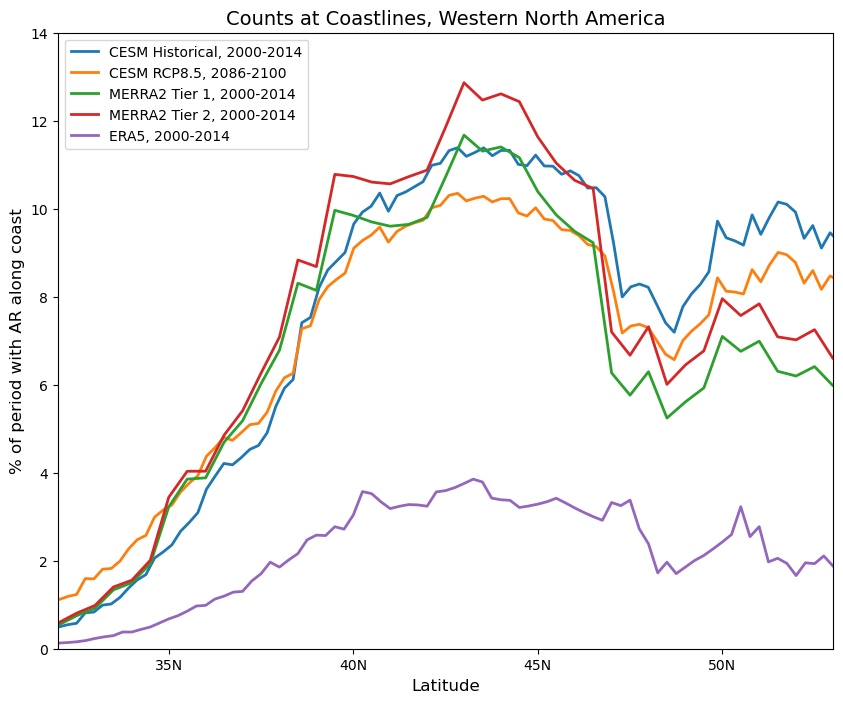

In [73]:
plt.figure(figsize=(10,8))
ARfreq_frac_zmean.plot(label='CESM Historical, 2000-2014', linewidth=2)
ARfreq_frac_zmean_rcp85.plot(label='CESM RCP8.5, 2086-2100', linewidth=2)
ARfreq_frac_zmean_merra.plot(label='MERRA2 Tier 1, 2000-2014', linewidth=2)
ARfreq_frac_zmean_merra_t2.plot(label='MERRA2 Tier 2, 2000-2014', linewidth=2)
ARfreq_frac_zmean_era.plot(label='ERA5, 2000-2014', linewidth=2)

plt.legend(fontsize=10, loc='upper left')

plt.xlabel('Latitude', fontsize=12)
plt.ylabel('% of period with AR along coast', fontsize=12)

plt.xlim(32,53)
plt.xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])

plt.ylim(0,14)

plt.title('Counts at Coastlines, Western North America', fontsize=14);

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_merra_era.png', dpi=300);

### Panel plots by season

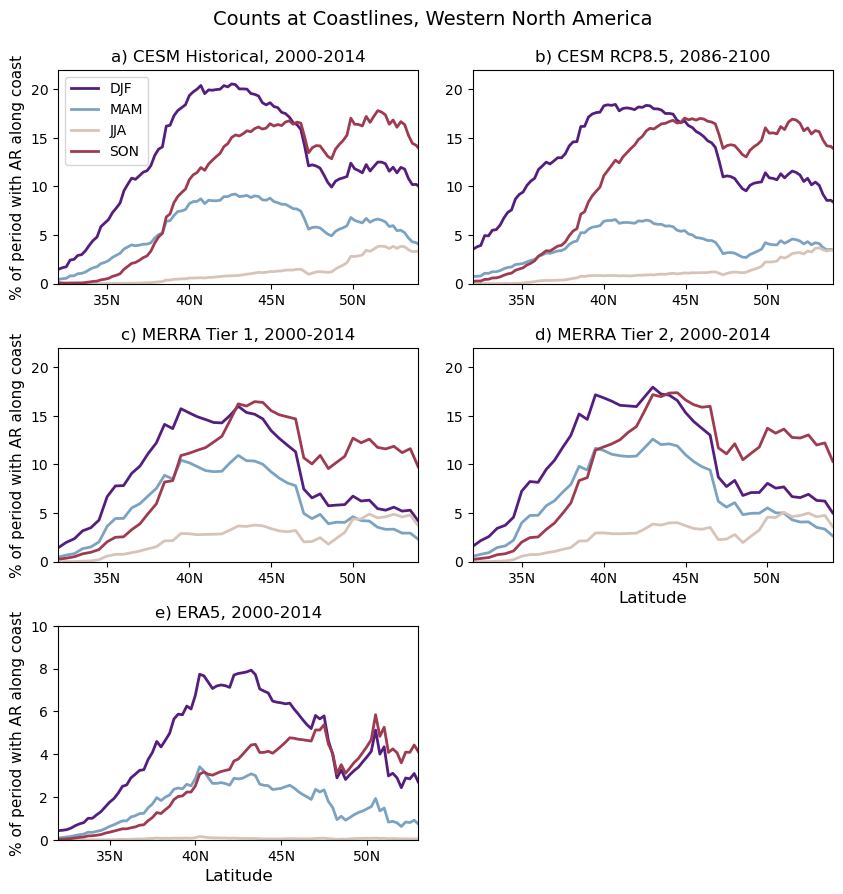

In [74]:
fig, ax = plt.subplots(3, 2, figsize=(10,10))

seasons = ['DJF', 'MAM', 'JJA', 'SON']

# set line colors to match monthly plots
cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.8, len(seasons)))

# CESM Hist
ax[0,0].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    ax[0,0].plot(ARfreq_frac_zmean_season.lat, ARfreq_frac_zmean_season.sel(season=s), label=s, linewidth=2)
ax[0,0].legend()
ax[0,0].set_xlim(32,54)
ax[0,0].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
#plt.xlabel('Latitude', fontsize=12)
ax[0,0].set_ylim(0,22)
ax[0,0].set_yticks([0,5,10,15,20]) 
ax[0,0].set_ylabel('% of period with AR along coast', fontsize=11)
ax[0,0].set_title('a) CESM Historical, 2000-2014')

# CESM RCP8.5
ax[0,1].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    ax[0,1].plot(ARfreq_frac_zmean_rcp85_season.lat, ARfreq_frac_zmean_rcp85_season.sel(season=s), label=s, linewidth=2)
ax[0,1].set_xlim(32,54)
ax[0,1].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax[0,1].set_ylim(0,22)
ax[0,1].set_yticks([0,5,10,15,20]) 
ax[0,1].set_title('b) CESM RCP8.5, 2086-2100')

# MERRA Tier 1
ax[1,0].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    ax[1,0].plot(ARfreq_frac_zmean_merra_season.lat, ARfreq_frac_zmean_merra_season.sel(season=s), label=s, linewidth=2)
ax[1,0].set_xlim(32,54)
ax[1,0].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax[1,0].set_ylim(0,22)
ax[1,0].set_yticks([0,5,10,15,20]) 
ax[1,0].set_ylabel('% of period with AR along coast', fontsize=11)
ax[1,0].set_title('c) MERRA Tier 1, 2000-2014')

# MERRA Tier 2
ax[1,1].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    ax[1,1].plot(ARfreq_frac_zmean_merra_t2_season.lat, ARfreq_frac_zmean_merra_t2_season.sel(season=s), label=s, linewidth=2)
ax[1,1].set_xlim(32,54)
ax[1,1].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax[1,1].set_xlabel('Latitude', fontsize=12)
ax[1,1].set_ylim(0,22)
ax[1,1].set_yticks([0,5,10,15,20]) 
ax[1,1].set_title('d) MERRA Tier 2, 2000-2014')

# ERA5
ax[2,0].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    ax[2,0].plot(ARfreq_frac_zmean_era_season.lat, ARfreq_frac_zmean_era_season.sel(season=s), label=s, linewidth=2)
ax[2,0].set_xlim(32,53)
ax[2,0].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax[2,0].set_xlabel('Latitude', fontsize=12)
ax[2,0].set_ylim(0,10)
ax[2,0].set_yticks([0,2,4,6,8, 10]) 
ax[2,0].set_ylabel('% of period with AR along coast', fontsize=11)
ax[2,0].set_title('e) ERA5, 2000-2014')

# empty panel
ax[2, 1].axis('off') # or ax[1, 1].set_visible(False)

# add suptitle
fig.suptitle('Counts at Coastlines, Western North America', fontsize=14, y=0.94);

plt.subplots_adjust(wspace=0.15, hspace=0.3)

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_season_WUS_CESM_merra_era.png', dpi=300)

### Panel plots by season with differences

#### Remap CESM hist to MERRA grid

In [80]:
ARcount_season = AR.groupby('time.season').sum(dim='time')

In [81]:
ARcount_season_merra = merra_ar.groupby('time.season').sum(dim='time')

In [82]:
%%time
regridder = xe.Regridder(ARcount_season, ARcount_season_merra, "bilinear") # don't use periodic=True here because its a region
regridder

CPU times: user 65.4 ms, sys: 31.6 ms, total: 96.9 ms
Wall time: 129 ms


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_98x49_47x25.nc 
Reuse pre-computed weights? False 
Input grid shape:           (98, 49) 
Output grid shape:          (47, 25) 
Periodic in longitude?      False

In [83]:
%%time
ARcount_season_merragrid = regridder(ARcount_season, keep_attrs=True)
ARcount_season_merragrid

CPU times: user 1.73 s, sys: 205 ms, total: 1.94 s
Wall time: 1.9 s


<xarray.DataArray 'masks' (season: 4, lat: 47, lon: 25)> Size: 38kB
dask.array<astype, shape=(4, 47, 25), dtype=int64, chunksize=(1, 47, 25), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0
  * lon      (lon) float32 100B -130.0 -129.4 -128.8 ... -116.2 -115.6 -115.0
Attributes:
    regrid_method:  bilinear

In [84]:
# have to do these steps manually because the function isn't setup to take ARcount; also use merra landfrac
ARfreq_frac_zmean_season_merragrid = 100*(ARcount_season_merragrid.where((merra_landfrac > 0) & (merra_landfrac < 0.99)).mean(dim='lon', skipna=True) / AR.time.groupby('time.season').count())
ARfreq_frac_zmean_season_merragrid

<xarray.DataArray (season: 4, lat: 47)> Size: 2kB
dask.array<mul, shape=(4, 47), dtype=float64, chunksize=(1, 47), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0

#### Remap CESM hist to ERA grid

In [86]:
ARcount_season_era = era_ar.groupby('time.season').sum(dim='time')

In [87]:
%%time
regridder = xe.Regridder(ARcount_season, ARcount_season_era, "bilinear") # don't use periodic=True here because its a region
regridder

CPU times: user 96.7 ms, sys: 2.02 ms, total: 98.7 ms
Wall time: 93.6 ms


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_98x49_93x61.nc 
Reuse pre-computed weights? False 
Input grid shape:           (98, 49) 
Output grid shape:          (93, 61) 
Periodic in longitude?      False

In [88]:
%%time
ARcount_season_eragrid = regridder(ARcount_season, keep_attrs=True)
ARcount_season_eragrid

CPU times: user 8.34 ms, sys: 0 ns, total: 8.34 ms
Wall time: 7.47 ms


<xarray.DataArray 'masks' (season: 4, lat: 93, lon: 61)> Size: 182kB
dask.array<astype, shape=(4, 93, 61), dtype=int64, chunksize=(1, 93, 49), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
  * lat      (lat) float32 372B 55.0 54.75 54.5 54.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 244B 230.0 230.2 230.5 230.8 ... 244.5 244.8 245.0
Attributes:
    regrid_method:  bilinear

In [90]:
# have to do these steps manually because the function isn't setup to take ARcount; also use era landfrac with modified upper bound
ARfreq_frac_zmean_season_eragrid = 100*(ARcount_season_eragrid.where((era_landfrac > 0) & (era_landfrac < 0.59)).mean(dim='lon', skipna=True) / AR.time.groupby('time.season').count())
ARfreq_frac_zmean_season_eragrid

<xarray.DataArray (season: 4, lat: 93)> Size: 3kB
dask.array<mul, shape=(4, 93), dtype=float64, chunksize=(1, 93), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
  * lat      (lat) float32 372B 55.0 54.75 54.5 54.25 ... 32.75 32.5 32.25 32.0
    time     datetime64[ns] 8B 1980-01-01

#### Calculate differences and plot

In [91]:
# MERRA Tier 1 - CESM Hist
ARfreq_frac_zmean_cesm_merra_season_diff = ARfreq_frac_zmean_merra_season - ARfreq_frac_zmean_season_merragrid

# MERRA Tier 2 - CESM Hist
ARfreq_frac_zmean_cesm_merra_t2_season_diff = ARfreq_frac_zmean_merra_t2_season - ARfreq_frac_zmean_season_merragrid

# ERA5 - CESM Hist
ARfreq_frac_zmean_cesm_era_season_diff = ARfreq_frac_zmean_era_season - ARfreq_frac_zmean_season_eragrid

# CESM RCP8.5 - Hist
ARfreq_frac_zmean_cesm_season_diff = ARfreq_frac_zmean_rcp85_season - ARfreq_frac_zmean_season

In [96]:
# max absolute values
print(ARfreq_frac_zmean_season.max().values, ARfreq_frac_zmean_merra_season.max().values, ARfreq_frac_zmean_merra_t2_season.max().values, 
      ARfreq_frac_zmean_era_season.max().values, ARfreq_frac_zmean_rcp85_season.max().values)

20.537037037037038 16.459096459096457 17.951440177252582 7.92712949286066 18.4320987654321


In [97]:
# min/max diff values - some of these might go outside plot domain
print(ARfreq_frac_zmean_cesm_merra_season_diff.min().values, ARfreq_frac_zmean_cesm_merra_t2_season_diff.min().values, 
      ARfreq_frac_zmean_cesm_era_season_diff.min().values, ARfreq_frac_zmean_cesm_season_diff.min().values)

print(ARfreq_frac_zmean_cesm_merra_season_diff.max().values, ARfreq_frac_zmean_cesm_merra_t2_season_diff.max().values, 
      ARfreq_frac_zmean_cesm_era_season_diff.max().values, ARfreq_frac_zmean_cesm_season_diff.max().values)

-7.957314404507905 -6.72254704852563 -15.718101343101345 -3.4601449275362324
6.936813186813187 7.478632478632479 0.42312900049236823 2.9490740740740735


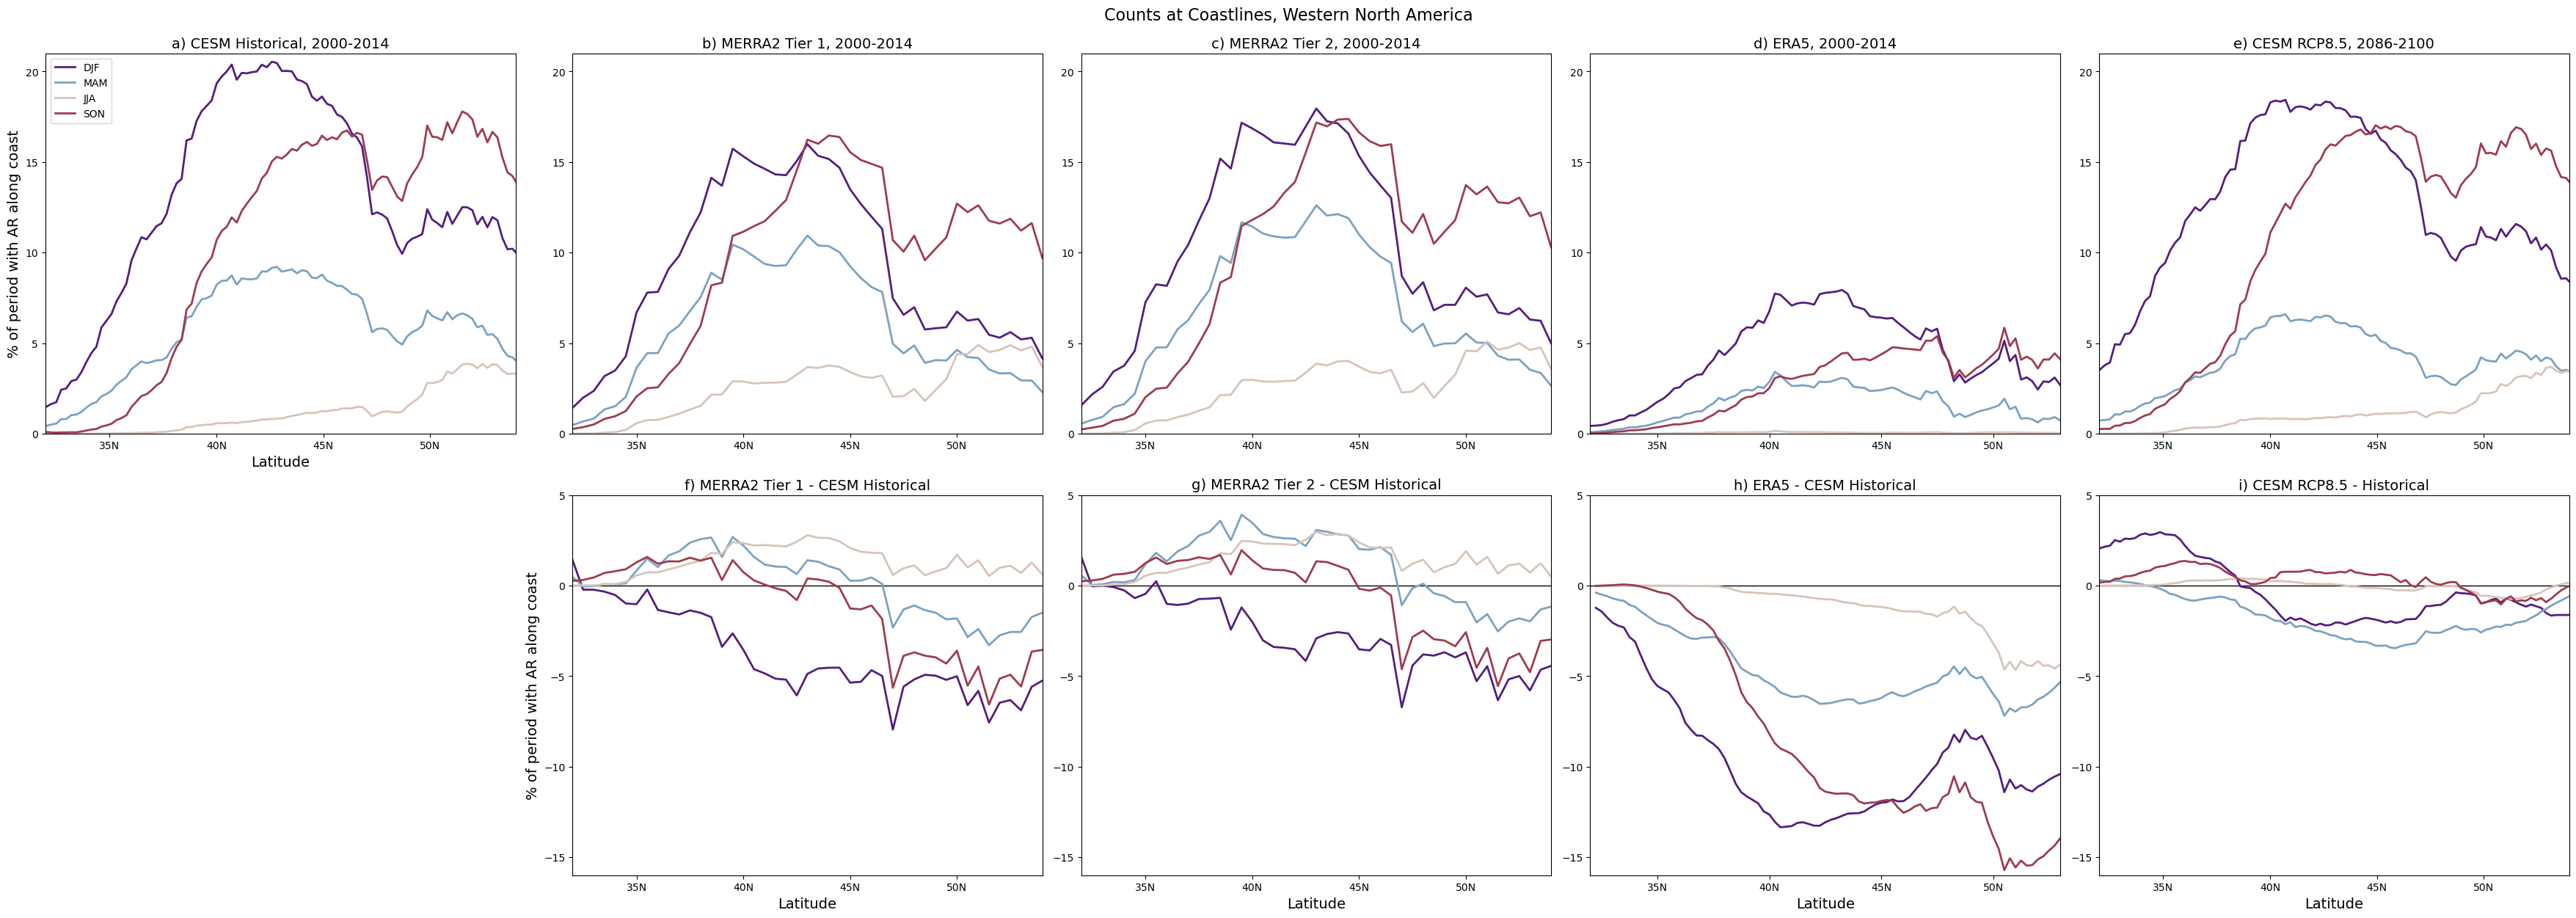

[WARNING] yaksa: 10 leaked handle pool objects


In [102]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper midleft', 'upper middle', 'upper midright', 'upper right'],
                               ['.', 'lower midleft', 'lower middle', 'lower midright', 'lower right']],
                              figsize=(35,12), layout="constrained")

seasons = ['DJF', 'MAM', 'JJA', 'SON']

# set line colors to match monthly plots
cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.8, len(seasons)))

# CESM Historical
ax['upper left'].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons): # need to enumerate otherwise it pulls the wrong seasons (not in chronological order)
    ax['upper left'].plot(ARfreq_frac_zmean_season.lat, ARfreq_frac_zmean_season.sel(season=s), label=s, linewidth=2)
ax['upper left'].legend()
#labelLines(ax['upper left'].get_lines(), zorder=2.5)
ax['upper left'].set_ylim(0,21)
ax['upper left'].set_yticks([0,5,10,15,20]) 
ax['upper left'].set_ylabel('% of period with AR along coast', fontsize=14)
ax['upper left'].set_xlim(32,54)
ax['upper left'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['upper left'].set_xlabel('Latitude', fontsize=14)
ax['upper left'].set_title('a) CESM Historical, 2000-2014', fontsize=14) 
ax['upper left'].legend()

# MERRA2 Tier 1
ax['upper midleft'].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    ax['upper midleft'].plot(ARfreq_frac_zmean_merra_season.lat, ARfreq_frac_zmean_merra_season.sel(season=s), label=s, linewidth=2)
#labelLines(ax['upper midleft'].get_lines(), zorder=2.5)
ax['upper midleft'].set_ylim(0,21)
ax['upper midleft'].set_yticks([0,5,10,15,20]) 
ax['upper midleft'].set_xlim(32,54)
ax['upper midleft'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['upper midleft'].set_title('b) MERRA2 Tier 1, 2000-2014', fontsize=14) 

# MERRA2 Tier 2
ax['upper middle'].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    ax['upper middle'].plot(ARfreq_frac_zmean_merra_t2_season.lat, ARfreq_frac_zmean_merra_t2_season.sel(season=s), label=s, linewidth=2)
#labelLines(ax['upper middle'].get_lines(), zorder=2.5)
ax['upper middle'].set_ylim(0,21)
ax['upper middle'].set_yticks([0,5,10,15,20]) 
ax['upper middle'].set_xlim(32,54)
ax['upper middle'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['upper middle'].set_title('c) MERRA2 Tier 2, 2000-2014', fontsize=14);

# ERA5
ax['upper midright'].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    ax['upper midright'].plot(ARfreq_frac_zmean_era_season.lat, ARfreq_frac_zmean_era_season.sel(season=s), label=s, linewidth=2)
#labelLines(ax['upper midright'].get_lines(), zorder=2.5)
ax['upper midright'].set_ylim(0,21)
ax['upper midright'].set_yticks([0,5,10,15,20]) 
ax['upper midright'].set_xlim(32,53)
ax['upper midright'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['upper midright'].set_title('d) ERA5, 2000-2014', fontsize=14);

# CESM RCP8.5
ax['upper right'].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    ax['upper right'].plot(ARfreq_frac_zmean_rcp85_season.lat, ARfreq_frac_zmean_rcp85_season.sel(season=s), label=s, linewidth=2)
#labelLines(ax['upper right'].get_lines(), zorder=2.5)
ax['upper right'].set_ylim(0,21)
ax['upper right'].set_yticks([0,5,10,15,20]) 
ax['upper right'].set_xlim(32,54)
ax['upper right'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['upper right'].set_title('e) CESM RCP8.5, 2086-2100', fontsize=14) 


# MERRA - CESM Hist (remapped)
ax['lower midleft'].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    # drop the last latitude index due to boundary issues with remapping
    ax['lower midleft'].plot(ARfreq_frac_zmean_cesm_merra_season_diff[:,:-1].lat, ARfreq_frac_zmean_cesm_merra_season_diff[:,:-1].sel(season=s), label=s, linewidth=2)
#labelLines(ax['lower midleft'].get_lines(), zorder=2.5)
ax['lower midleft'].axhline(y=0, color='k', linewidth=1, zorder=0)
ax['lower midleft'].set_ylim(-16,5)
ax['lower midleft'].set_yticks([-15,-10,-5,0,5])
ax['lower midleft'].set_xlim(32,54)
ax['lower midleft'].set_ylabel('% of period with AR along coast', fontsize=14)
ax['lower midleft'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['lower midleft'].set_xlabel('Latitude', fontsize=14)
ax['lower midleft'].set_title('f) MERRA2 Tier 1 - CESM Historical', fontsize=14) 

# MERRA Tier 2 - CESM Hist (remapped)
ax['lower middle'].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    # drop the last latitude index due to boundary issues with remapping
    ax['lower middle'].plot(ARfreq_frac_zmean_cesm_merra_t2_season_diff[:,:-1].lat, ARfreq_frac_zmean_cesm_merra_t2_season_diff[:,:-1].sel(season=s), label=s, linewidth=2)
#labelLines(ax['lower middle'].get_lines(), zorder=2.5)
ax['lower middle'].axhline(y=0, color='k', linewidth=1, zorder=0)
ax['lower middle'].set_ylim(-16,5)
ax['lower middle'].set_yticks([-15,-10,-5,0,5])
ax['lower middle'].set_xlim(32,54)
ax['lower middle'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['lower middle'].set_xlabel('Latitude', fontsize=14)
ax['lower middle'].set_title('g) MERRA2 Tier 2 - CESM Historical', fontsize=14);

# ERA - CESM Hist (remapped)
ax['lower midright'].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    # drop the last latitude index due to boundary issues with remapping
    # Also drop highest several latitudes due to lack of data at those points - otherwise labelLines doesn't work
    ax['lower midright'].plot(ARfreq_frac_zmean_cesm_era_season_diff[:,7:-1].lat, ARfreq_frac_zmean_cesm_era_season_diff[:,7:-1].sel(season=s), label=s, linewidth=2)
#labelLines(ax['lower midright'].get_lines(), zorder=2.5)
ax['lower midright'].axhline(y=0, color='k', linewidth=1, zorder=0)
ax['lower midright'].set_ylim(-16,5)
ax['lower midright'].set_yticks([-15,-10,-5,0,5])
ax['lower midright'].set_xlim(32,53)
ax['lower midright'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['lower midright'].set_xlabel('Latitude', fontsize=14)
ax['lower midright'].set_title('h) ERA5 - CESM Historical', fontsize=14);

# CESM RCP - Historical
ax['lower right'].set_prop_cycle('color', list(cm))
for i,s in enumerate(seasons):
    ax['lower right'].plot(ARfreq_frac_zmean_cesm_season_diff.lat, ARfreq_frac_zmean_cesm_season_diff.sel(season=s), label=s, linewidth=2)
#labelLines(ax['lower right'].get_lines(), zorder=2.5)
ax['lower right'].axhline(y=0, color='k', linewidth=1, zorder=0)
ax['lower right'].set_ylim([-16,5])
ax['lower right'].set_yticks([-15,-10,-5,0,5])
ax['lower right'].set_xlim(32,54)
ax['lower right'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['lower right'].set_xlabel('Latitude', fontsize=14)
ax['lower right'].set_title('i) CESM RCP8.5 - Historical', fontsize=14) 

#plt.legend()

fig.suptitle('Counts at Coastlines, Western North America', fontsize=16, y=1.03);

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_season_WUS_CESM_merra_era_diffs.png', bbox_inches='tight', dpi=300)

## Counts by Month

In [75]:
def counts_at_coastlines_month(AR, landfrac):
    ARcount = AR.groupby('time.month').sum(dim='time')
    ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 0.99))
    ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
    ARfreq_frac_zmean_bymonth = 100*(ARcount_frac_zmean / AR.time.groupby('time.month').count())
    return(ARfreq_frac_zmean_bymonth)

In [76]:
ARfreq_frac_zmean_bymonth = counts_at_coastlines_month(AR, landfrac)
ARfreq_frac_zmean_bymonth

<xarray.DataArray (month: 12, lat: 98)> Size: 9kB
dask.array<mul, shape=(12, 98), dtype=float64, chunksize=(1, 98), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 784B 32.03 32.27 32.5 32.74 ... 54.33 54.56 54.8
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

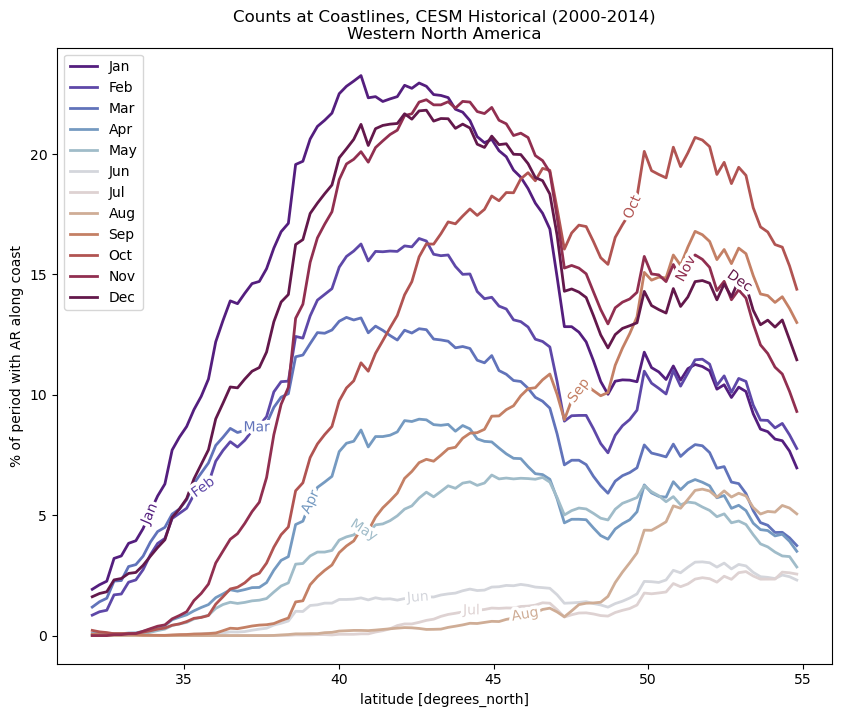

In [77]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))
#cm = plt.cm.Set3(np.linspace(0, 1, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

ax.plot(ARfreq_frac_zmean_bymonth.lat, ARfreq_frac_zmean_bymonth.transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, CESM Historical (2000-2014)\nWestern North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_hist_rcp26_bymonth_labels.png');

In [78]:
ARfreq_frac_zmean_rcp85_bymonth = counts_at_coastlines_month(AR_rcp85, landfrac)

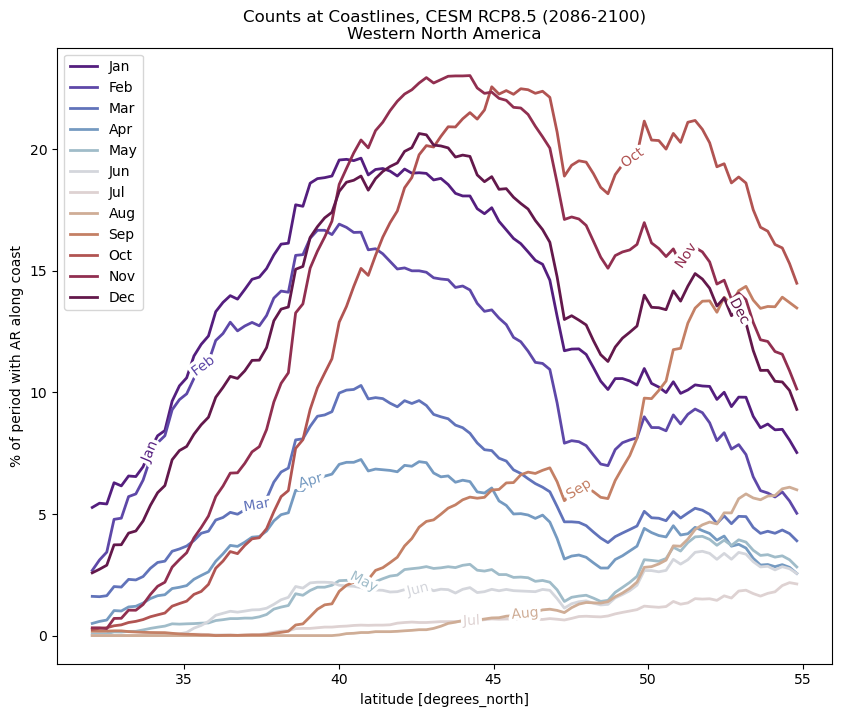

In [79]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

ax.plot(ARfreq_frac_zmean_rcp85_bymonth.lat, ARfreq_frac_zmean_rcp85_bymonth.transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, CESM RCP8.5 (2086-2100)\nWestern North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_rcp85_bymonth_labels.png');

In [80]:
# CESM diff
ARfreq_frac_zmean_cesm_bymonth_diff = ARfreq_frac_zmean_rcp85_bymonth - ARfreq_frac_zmean_bymonth

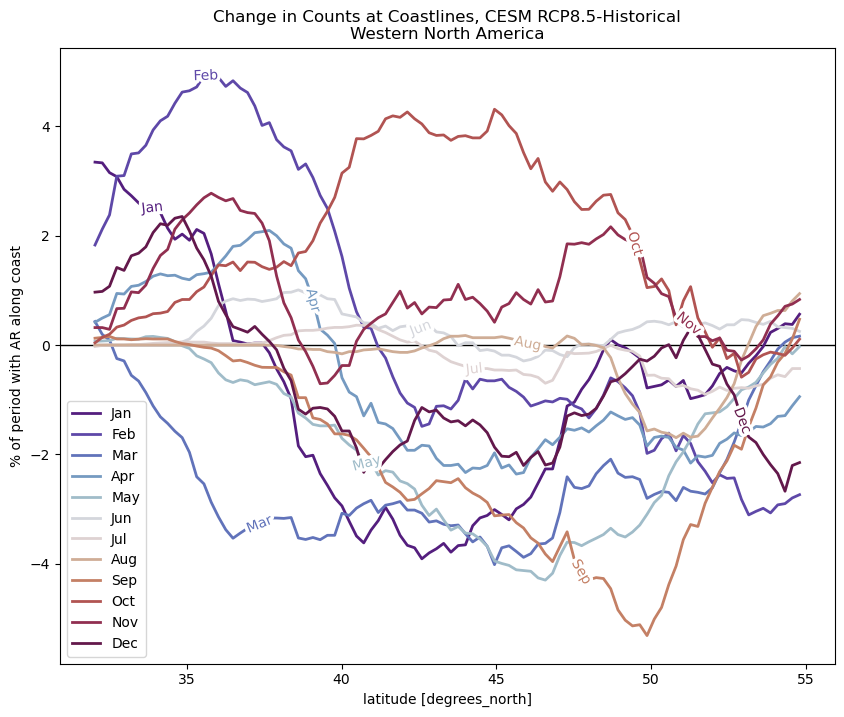

In [138]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

ax.plot(ARfreq_frac_zmean_cesm_bymonth_diff.lat, ARfreq_frac_zmean_cesm_bymonth_diff.transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.axhline(y=0, color='k', linewidth=1, zorder=0)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Change in Counts at Coastlines, CESM RCP8.5-Historical\nWestern North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_diff_bymonth_labels.png');

### MERRA counts by month

In [87]:
ARfreq_frac_zmean_merra_bymonth = counts_at_coastlines_month(merra_ar, merra_landfrac)
ARfreq_frac_zmean_merra_bymonth

<xarray.DataArray (month: 12, lat: 47)> Size: 5kB
dask.array<mul, shape=(12, 47), dtype=float64, chunksize=(1, 47), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

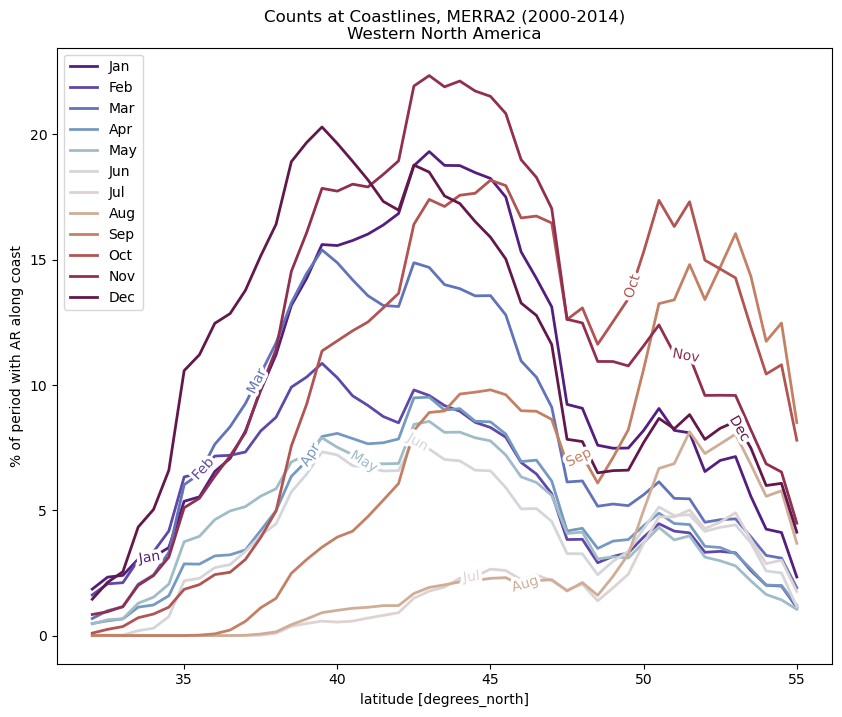

In [62]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

ax.plot(ARfreq_frac_zmean_merra_bymonth.lat, ARfreq_frac_zmean_merra_bymonth.transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, MERRA2 (2000-2014)\nWestern North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_merra_bymonth_labels.png');

In [88]:
ARfreq_frac_zmean_merra_t2_bymonth = counts_at_coastlines_month(merra_ar_t2, merra_landfrac)
ARfreq_frac_zmean_merra_t2_bymonth

<xarray.DataArray (month: 12, lat: 47)> Size: 5kB
dask.array<mul, shape=(12, 47), dtype=float64, chunksize=(1, 47), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

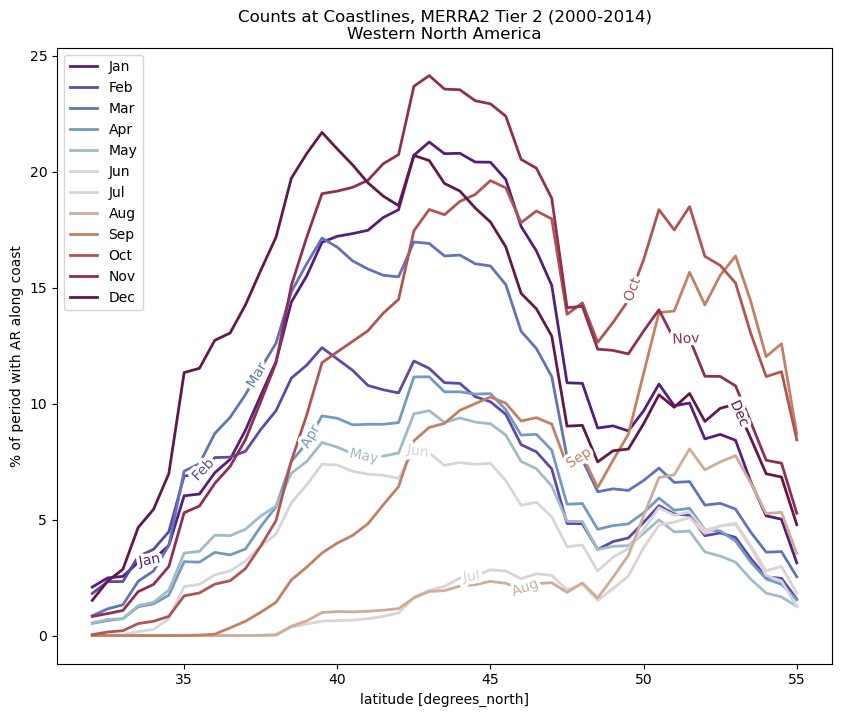

In [64]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

ax.plot(ARfreq_frac_zmean_merra_t2_bymonth.lat, ARfreq_frac_zmean_merra_t2_bymonth.transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, MERRA2 Tier 2 (2000-2014)\nWestern North America');

### Difference plot between CESM historical and MERRA
This doesn't work out of the box due to different horizontal resolutions\
First remap CESM hist to MERRA grid\
Which field to remap? Remapping doesn't work well with masks, so pick a continuous gridded field at the earliest processing level.

In [81]:
ARcount = AR.groupby('time.month').sum(dim='time')
#ARcount.isel(month=0).plot()

In [82]:
ARcount_merra = merra_ar.groupby('time.month').sum(dim='time')

In [83]:
%%time
regridder = xe.Regridder(ARcount, ARcount_merra, "bilinear") # don't use periodic=True here because its a region
regridder

CPU times: user 63 ms, sys: 33.2 ms, total: 96.3 ms
Wall time: 149 ms


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_98x49_47x25.nc 
Reuse pre-computed weights? False 
Input grid shape:           (98, 49) 
Output grid shape:          (47, 25) 
Periodic in longitude?      False

In [84]:
%%time
ARcount_merragrid = regridder(ARcount, keep_attrs=True)
ARcount_merragrid

CPU times: user 1.7 s, sys: 240 ms, total: 1.94 s
Wall time: 2.01 s


<xarray.DataArray 'masks' (month: 12, lat: 47, lon: 25)> Size: 113kB
dask.array<astype, shape=(12, 47, 25), dtype=int64, chunksize=(1, 47, 25), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0
  * lon      (lon) float32 100B -130.0 -129.4 -128.8 ... -116.2 -115.6 -115.0
Attributes:
    regrid_method:  bilinear

In [85]:
# have to do these steps manually because the function isn't setup to take ARcount; also use merra landfrac
ARfreq_frac_zmean_bymonth_merragrid = 100*(ARcount_merragrid.where((merra_landfrac > 0) & (merra_landfrac < 0.99)).mean(dim='lon', skipna=True) / AR.time.groupby('time.month').count())
ARfreq_frac_zmean_bymonth_merragrid

<xarray.DataArray (month: 12, lat: 47)> Size: 5kB
dask.array<mul, shape=(12, 47), dtype=float64, chunksize=(1, 47), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0

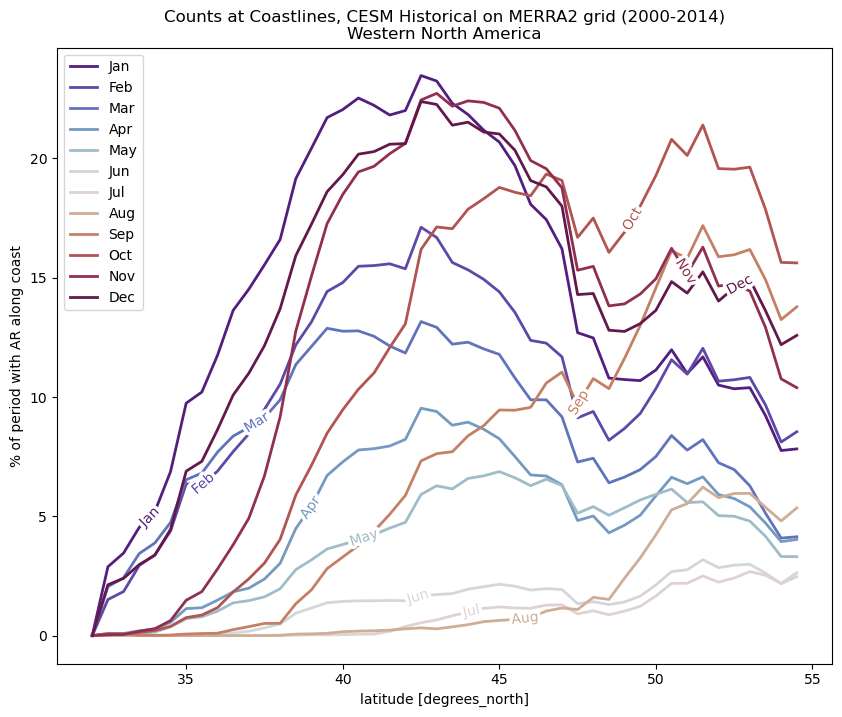

In [71]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

ax.plot(ARfreq_frac_zmean_bymonth_merragrid[:,:-1].lat, ARfreq_frac_zmean_bymonth_merragrid[:,:-1].transpose(), label=months, linewidth=2) # drop the last index due to regridding issues

labelLines(ax.get_lines(), zorder=2.5)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, CESM Historical on MERRA2 grid (2000-2014)\nWestern North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_merra_bymonth_labels.png');

In [89]:
# MERRA - CESM hist
ARfreq_frac_zmean_cesm_merra_bymonth_diff = ARfreq_frac_zmean_merra_bymonth - ARfreq_frac_zmean_bymonth_merragrid
ARfreq_frac_zmean_cesm_merra_bymonth_diff

<xarray.DataArray (month: 12, lat: 47)> Size: 5kB
dask.array<sub, shape=(12, 47), dtype=float64, chunksize=(1, 47), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

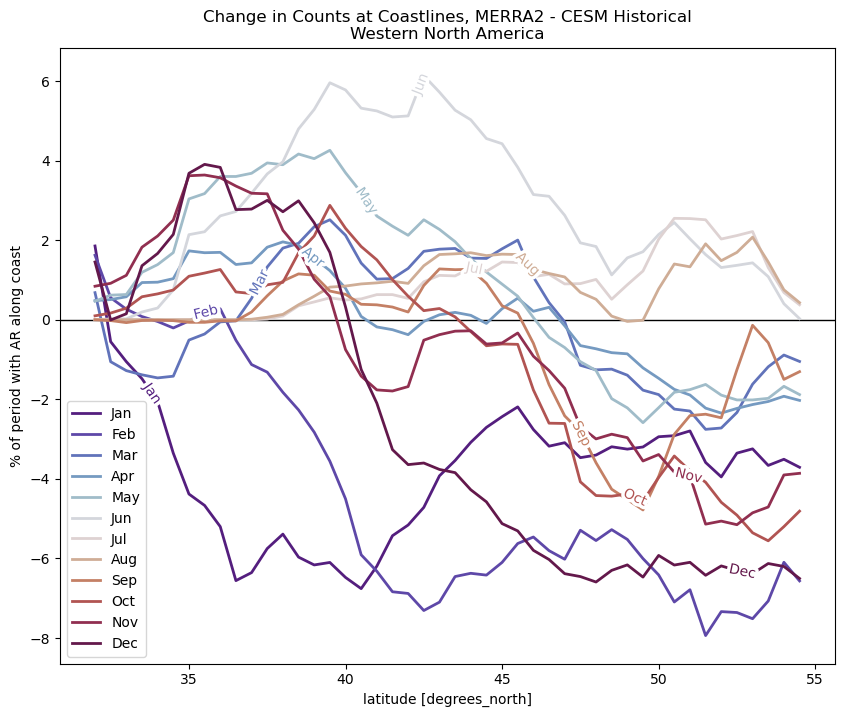

In [73]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

#ax.plot(ARfreq_frac_zmean_cesm_merra_bymonth_diff.lat, ARfreq_frac_zmean_cesm_merra_bymonth_diff.transpose(), label=months, linewidth=2)
# drop the last latitude index due to boundary issues with remapping
ax.plot(ARfreq_frac_zmean_cesm_merra_bymonth_diff[:,:-1].lat, ARfreq_frac_zmean_cesm_merra_bymonth_diff[:,:-1].transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.axhline(y=0, color='k', linewidth=1, zorder=0)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Change in Counts at Coastlines, MERRA2 - CESM Historical\nWestern North America');

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_diff_bymonth_labels.png');

In [90]:
# MERRA Tier 2 - CESM hist
ARfreq_frac_zmean_cesm_merra_t2_bymonth_diff = ARfreq_frac_zmean_merra_t2_bymonth - ARfreq_frac_zmean_bymonth_merragrid
ARfreq_frac_zmean_cesm_merra_t2_bymonth_diff

<xarray.DataArray (month: 12, lat: 47)> Size: 5kB
dask.array<sub, shape=(12, 47), dtype=float64, chunksize=(1, 47), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 188B 32.0 32.5 33.0 33.5 34.0 ... 53.5 54.0 54.5 55.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

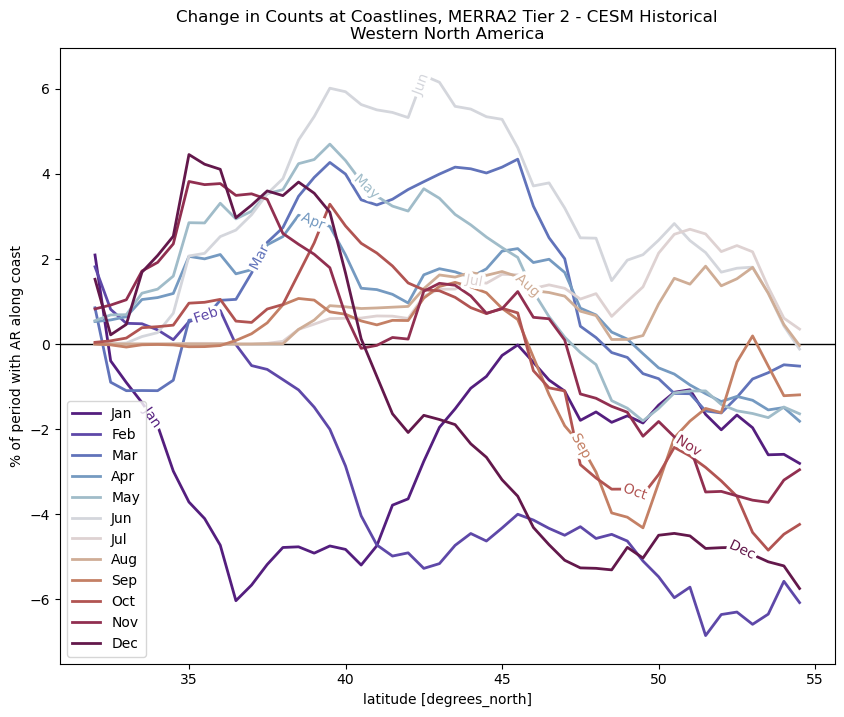

In [75]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

# drop the last latitude index due to boundary issues with remapping
ax.plot(ARfreq_frac_zmean_cesm_merra_t2_bymonth_diff[:,:-1].lat, ARfreq_frac_zmean_cesm_merra_t2_bymonth_diff[:,:-1].transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.axhline(y=0, color='k', linewidth=1, zorder=0)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Change in Counts at Coastlines, MERRA2 Tier 2 - CESM Historical\nWestern North America');

### Panel plot

CESM Hist and diffs only

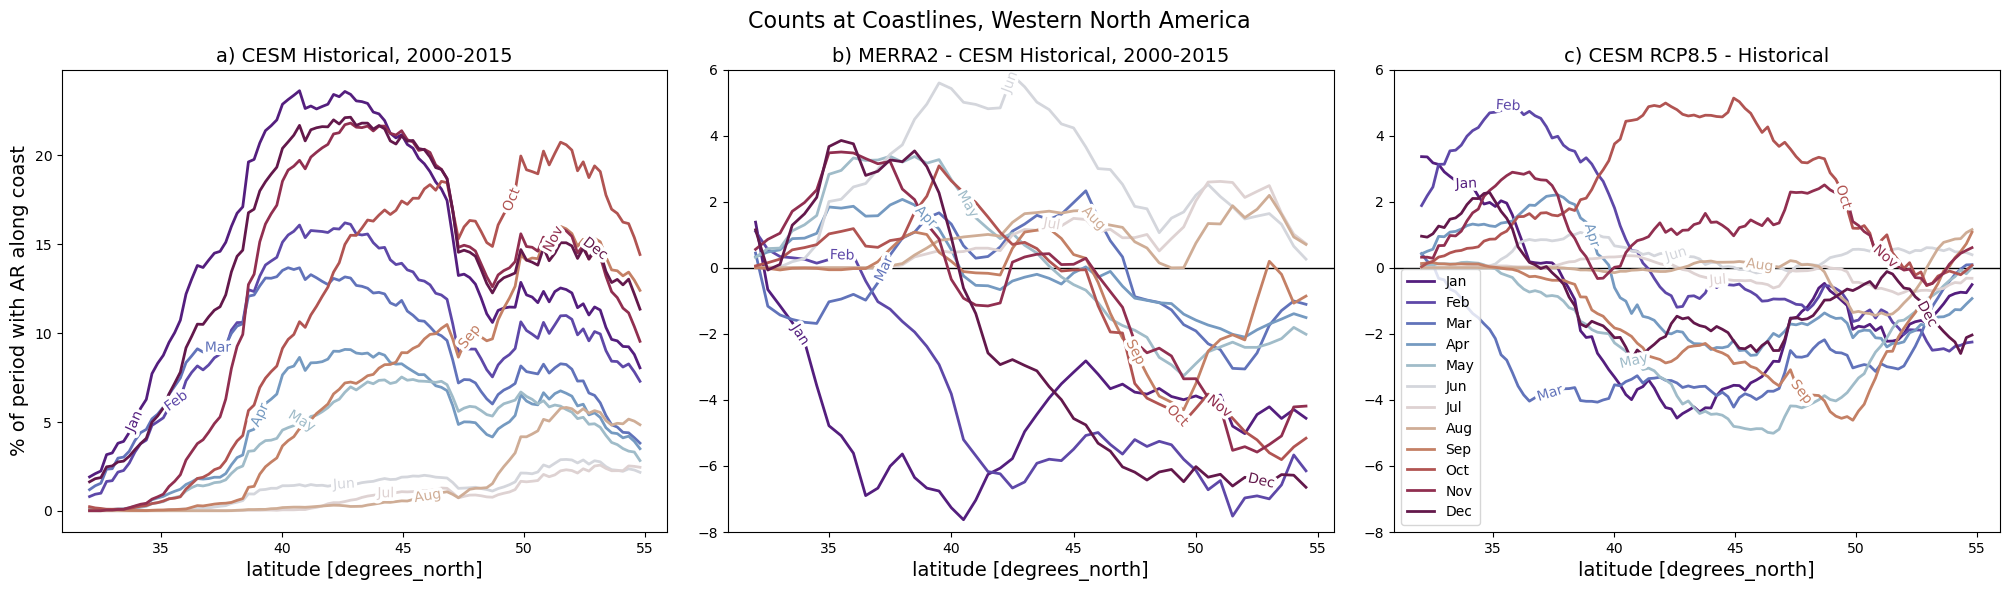

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(25,6))

axs = axs.ravel()

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

# CESM Historical
axs[0].set_prop_cycle('color', list(cm))
axs[0].plot(ARfreq_frac_zmean_bymonth.lat, ARfreq_frac_zmean_bymonth.transpose(), label=months, linewidth=2)
labelLines(axs[0].get_lines(), zorder=2.5)
axs[0].set_ylabel('% of period with AR along coast', fontsize=14)
axs[0].set_xlabel('latitude [degrees_north]', fontsize=14)
axs[0].set_title('a) CESM Historical, 2000-2015', fontsize=14) 

# MERRA - CESM Hist (remapped)
axs[1].set_prop_cycle('color', list(cm))
# drop the last latitude index due to boundary issues with remapping
axs[1].plot(ARfreq_frac_zmean_cesm_merra_bymonth_diff[:,:-1].lat, ARfreq_frac_zmean_cesm_merra_bymonth_diff[:,:-1].transpose(), label=months, linewidth=2)
labelLines(axs[1].get_lines(), zorder=2.5)
axs[1].axhline(y=0, color='k', linewidth=1, zorder=0)
axs[1].set_ylim([-8,6])
axs[1].set_xlabel('latitude [degrees_north]', fontsize=14)
axs[1].set_title('b) MERRA2 - CESM Historical, 2000-2015', fontsize=14) 

# CESM RCP - Historical
axs[2].set_prop_cycle('color', list(cm))
axs[2].plot(ARfreq_frac_zmean_cesm_bymonth_diff.lat, ARfreq_frac_zmean_cesm_bymonth_diff.transpose(), label=months, linewidth=2)
labelLines(axs[2].get_lines(), zorder=2.5)
axs[2].axhline(y=0, color='k', linewidth=1, zorder=0)
axs[2].set_ylim([-8,6])
axs[2].set_xlabel('latitude [degrees_north]', fontsize=14)
axs[2].set_title('c) CESM RCP8.5 - Historical', fontsize=14) 

plt.legend()

fig.suptitle('Counts at Coastlines, Western North America', fontsize=16, y=0.98);

plt.subplots_adjust(wspace=0.1, hspace=0)

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_MERRA_diffs_bymonth_labels.png');

### CESM and MERRA comparisons

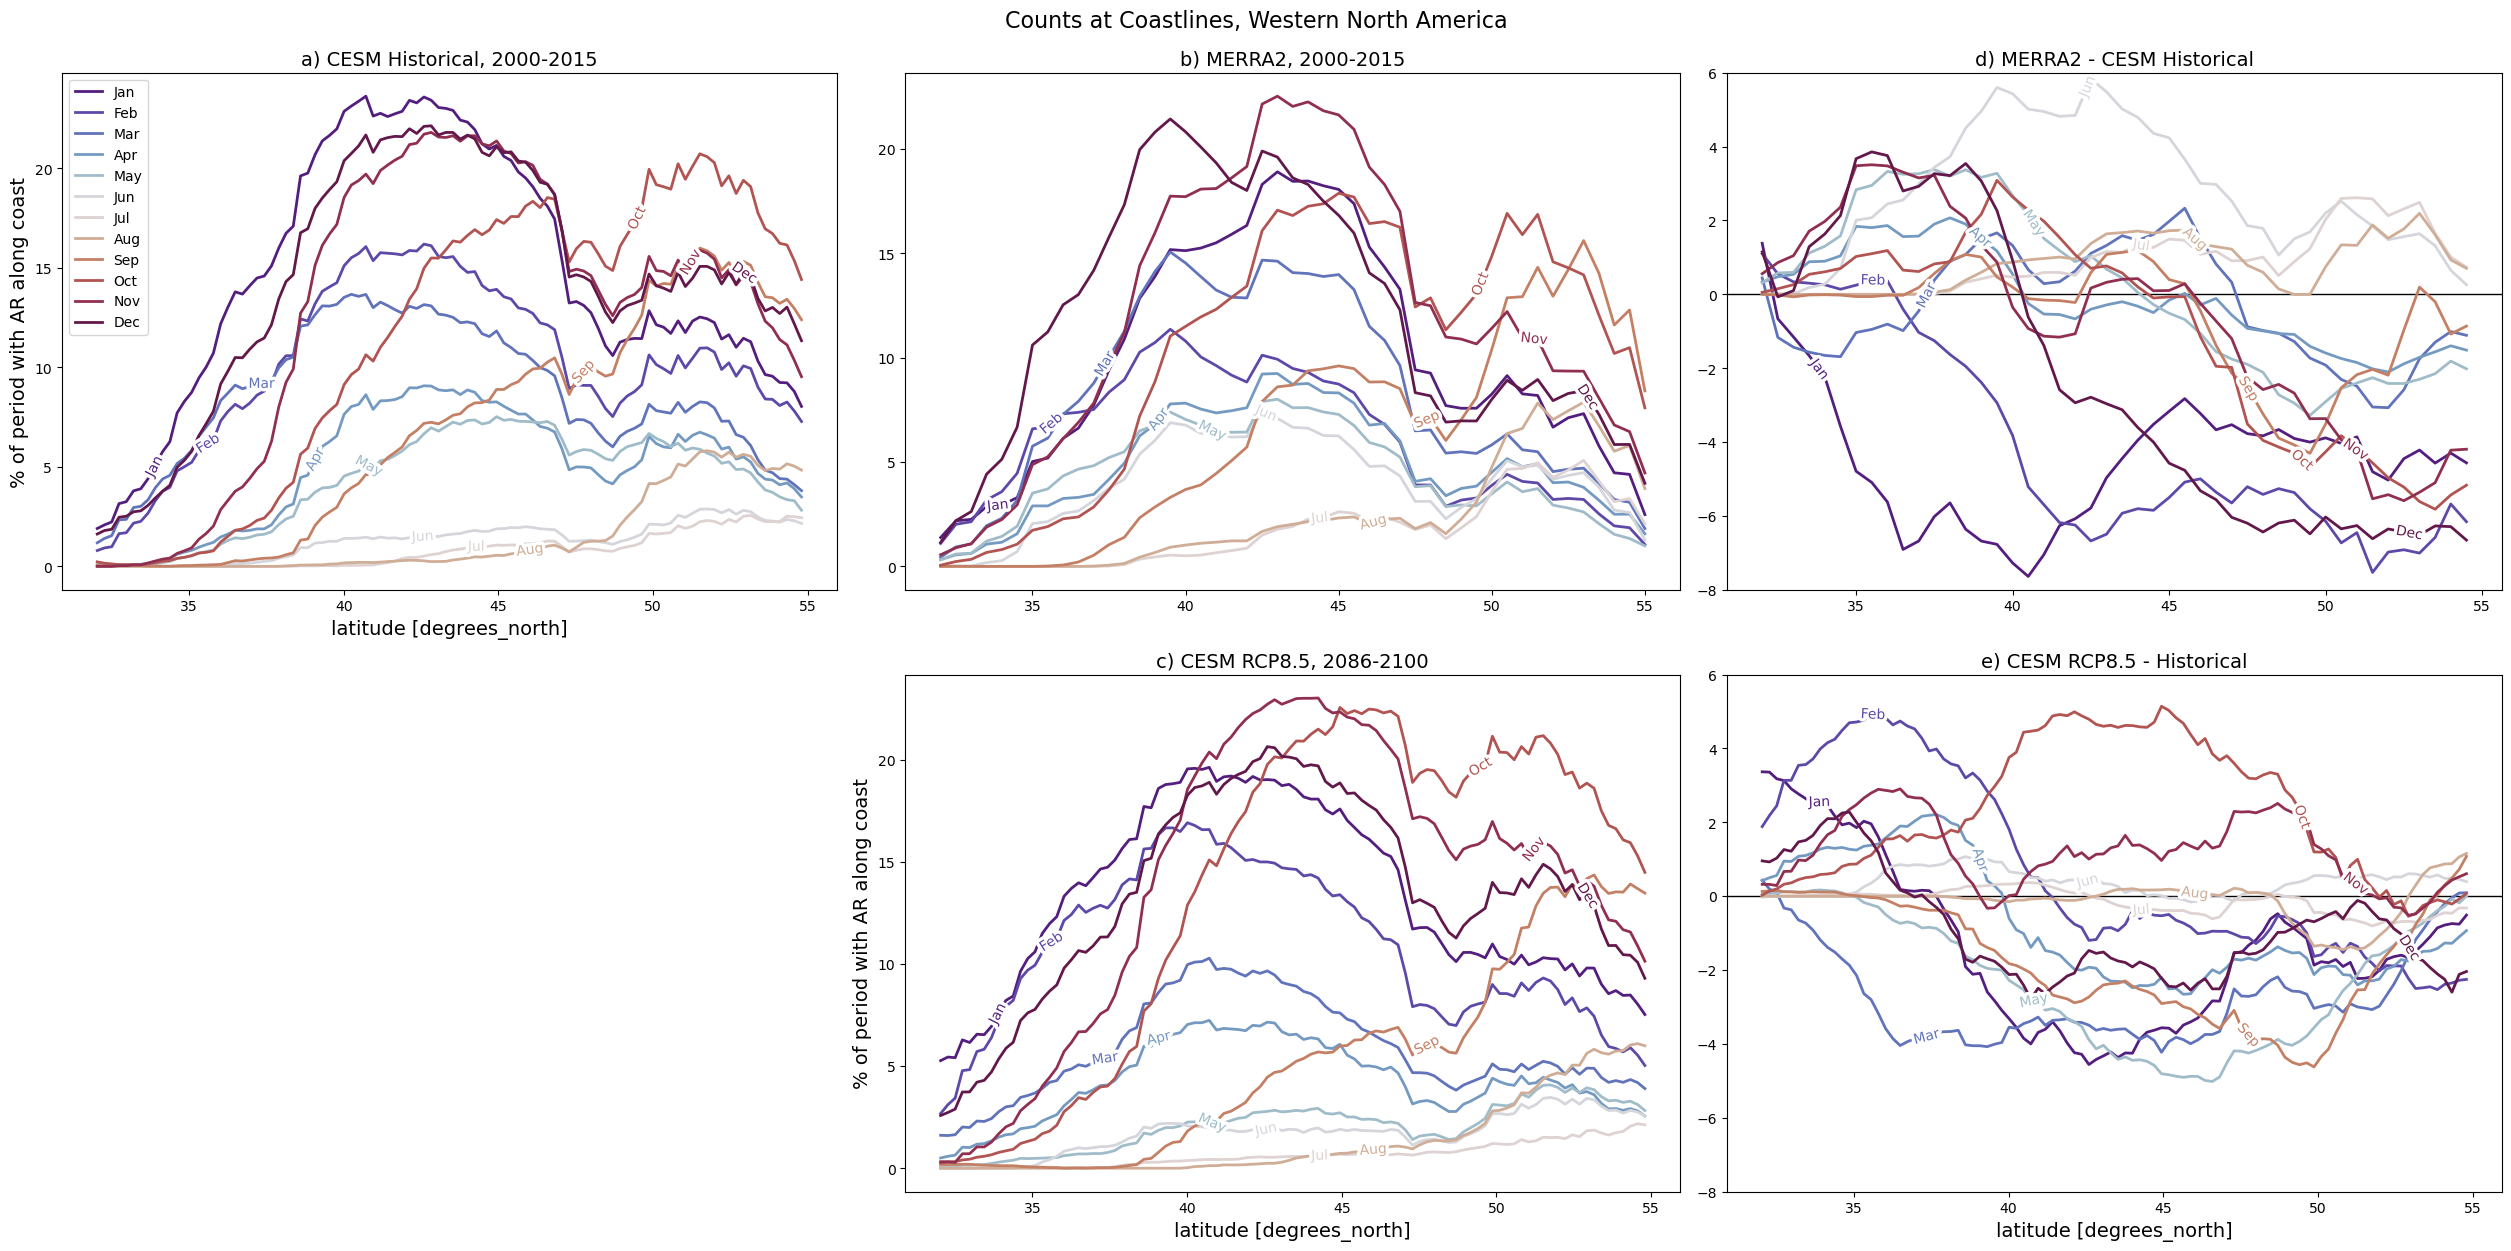

In [95]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper middle', 'upper right'],
                               ['.', 'lower middle', 'lower right']],
                              figsize=(25,12), layout="constrained")

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

# CESM Historical
ax['upper left'].set_prop_cycle('color', list(cm))
ax['upper left'].plot(ARfreq_frac_zmean_bymonth.lat, ARfreq_frac_zmean_bymonth.transpose(), label=months, linewidth=2)
labelLines(ax['upper left'].get_lines(), zorder=2.5)
ax['upper left'].set_ylabel('% of period with AR along coast', fontsize=14)
ax['upper left'].set_xlabel('latitude [degrees_north]', fontsize=14)
ax['upper left'].set_title('a) CESM Historical, 2000-2015', fontsize=14) 
ax['upper left'].legend()

# MERRA2
ax['upper middle'].set_prop_cycle('color', list(cm))
ax['upper middle'].plot(ARfreq_frac_zmean_merra_bymonth.lat, ARfreq_frac_zmean_merra_bymonth.transpose(), label=months, linewidth=2)
labelLines(ax['upper middle'].get_lines(), zorder=2.5)
#ax['upper middle'].set_ylabel('% of period with AR along coast', fontsize=14)
#ax['upper middle'].set_xlabel('latitude [degrees_north]', fontsize=14)
ax['upper middle'].set_title('b) MERRA2, 2000-2015', fontsize=14) 

# CESM RCP8.5
ax['lower middle'].set_prop_cycle('color', list(cm))
ax['lower middle'].plot(ARfreq_frac_zmean_rcp85_bymonth.lat, ARfreq_frac_zmean_rcp85_bymonth.transpose(), label=months, linewidth=2)
labelLines(ax['lower middle'].get_lines(), zorder=2.5)
ax['lower middle'].set_ylabel('% of period with AR along coast', fontsize=14)
ax['lower middle'].set_xlabel('latitude [degrees_north]', fontsize=14)
ax['lower middle'].set_title('c) CESM RCP8.5, 2086-2100', fontsize=14) 

# MERRA - CESM Hist (remapped)
ax['upper right'].set_prop_cycle('color', list(cm))
# drop the last latitude index due to boundary issues with remapping
ax['upper right'].plot(ARfreq_frac_zmean_cesm_merra_bymonth_diff[:,:-1].lat, ARfreq_frac_zmean_cesm_merra_bymonth_diff[:,:-1].transpose(), label=months, linewidth=2)
labelLines(ax['upper right'].get_lines(), zorder=2.5)
ax['upper right'].axhline(y=0, color='k', linewidth=1, zorder=0)
ax['upper right'].set_ylim([-8,6])
#ax['upper right'].set_xlabel('latitude [degrees_north]', fontsize=14)
ax['upper right'].set_title('d) MERRA2 - CESM Historical', fontsize=14) 

# CESM RCP - Historical
ax['lower right'].set_prop_cycle('color', list(cm))
ax['lower right'].plot(ARfreq_frac_zmean_cesm_bymonth_diff.lat, ARfreq_frac_zmean_cesm_bymonth_diff.transpose(), label=months, linewidth=2)
labelLines(ax['lower right'].get_lines(), zorder=2.5)
ax['lower right'].axhline(y=0, color='k', linewidth=1, zorder=0)
ax['lower right'].set_ylim([-8,6])
ax['lower right'].set_xlabel('latitude [degrees_north]', fontsize=14)
ax['lower right'].set_title('e) CESM RCP8.5 - Historical', fontsize=14) 

#plt.legend()

fig.suptitle('Counts at Coastlines, Western North America', fontsize=16, y=1.03);

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_MERRA_allplots_bymonth_labels.png', bbox_inches='tight', dpi=300)

### ERA5 monthly counts

In [24]:
def counts_at_coastlines_month_era(AR, landfrac):
    ARcount = AR.groupby('time.month').sum(dim='time')
    ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 0.59)) # modified upper bound
    ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
    ARfreq_frac_zmean_bymonth = 100*(ARcount_frac_zmean / AR.time.groupby('time.month').count())
    return(ARfreq_frac_zmean_bymonth)

In [26]:
ARfreq_frac_zmean_era_bymonth = counts_at_coastlines_month_era(era_ar, era_landfrac)
ARfreq_frac_zmean_era_bymonth

<xarray.DataArray (month: 12, lat: 93)> Size: 9kB
dask.array<mul, shape=(12, 93), dtype=float64, chunksize=(1, 93), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 372B 55.0 54.75 54.5 54.25 ... 32.75 32.5 32.25 32.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    time     datetime64[ns] 8B 1980-01-01

Highest latitude have missing data and due to plotting strategy and labeling for monthly lines, I need to subset for the latitude indices with non-missing data\
Did not have to do this for seasonal/annual plots and could just modify the xlim

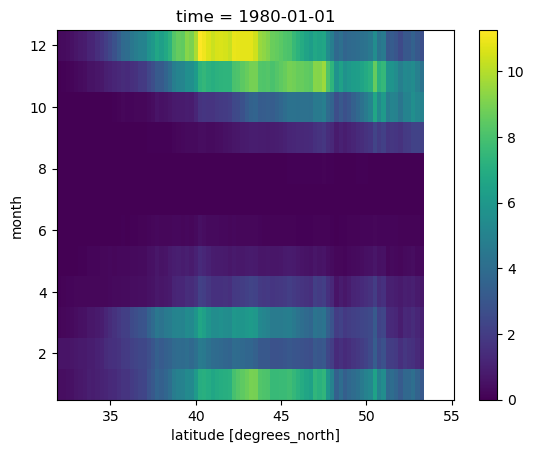

In [107]:
ARfreq_frac_zmean_era_bymonth.plot()

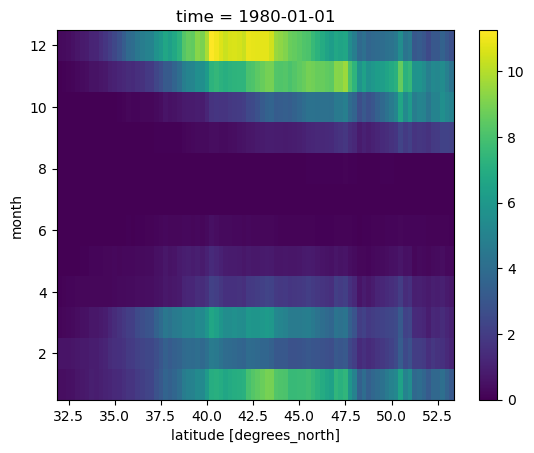

In [113]:
ARfreq_frac_zmean_era_bymonth[:,7:].plot()

In [106]:
ARfreq_frac_zmean_era_bymonth[:,7:].lat

<xarray.DataArray 'lat' (lat: 86)> Size: 344B
array([53.25, 53.  , 52.75, 52.5 , 52.25, 52.  , 51.75, 51.5 , 51.25, 51.  ,
       50.75, 50.5 , 50.25, 50.  , 49.75, 49.5 , 49.25, 49.  , 48.75, 48.5 ,
       48.25, 48.  , 47.75, 47.5 , 47.25, 47.  , 46.75, 46.5 , 46.25, 46.  ,
       45.75, 45.5 , 45.25, 45.  , 44.75, 44.5 , 44.25, 44.  , 43.75, 43.5 ,
       43.25, 43.  , 42.75, 42.5 , 42.25, 42.  , 41.75, 41.5 , 41.25, 41.  ,
       40.75, 40.5 , 40.25, 40.  , 39.75, 39.5 , 39.25, 39.  , 38.75, 38.5 ,
       38.25, 38.  , 37.75, 37.5 , 37.25, 37.  , 36.75, 36.5 , 36.25, 36.  ,
       35.75, 35.5 , 35.25, 35.  , 34.75, 34.5 , 34.25, 34.  , 33.75, 33.5 ,
       33.25, 33.  , 32.75, 32.5 , 32.25, 32.  ], dtype=float32)
Coordinates:
  * lat      (lat) float32 344B 53.25 53.0 52.75 52.5 ... 32.75 32.5 32.25 32.0
    time     datetime64[ns] 8B 1980-01-01
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

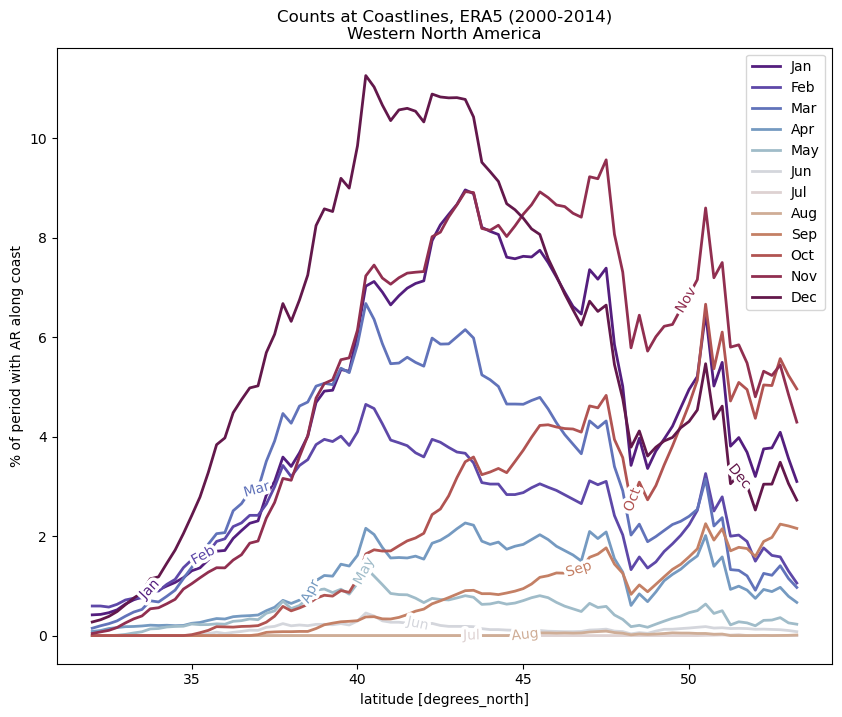

In [101]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

#ax.plot(ARfreq_frac_zmean_era_bymonth.lat, ARfreq_frac_zmean_era_bymonth.transpose(), label=months, linewidth=2)
# Drop highest several latitudes due to lack of data at those points - otherwise labelLines doesn't work
ax.plot(ARfreq_frac_zmean_era_bymonth[:,7:].lat, ARfreq_frac_zmean_era_bymonth[:,7:].transpose(), label=months, linewidth=2)


labelLines(ax.get_lines(), zorder=2.5)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, ERA5 (2000-2014)\nWestern North America');

### Difference plot between CESM historical and ERA
Remap CESM hist to ERA grid

In [91]:
ARcount_era = era_ar.groupby('time.month').sum(dim='time')

In [92]:
%%time
regridder = xe.Regridder(ARcount, ARcount_era, "bilinear") # don't use periodic=True here because its a region
regridder

CPU times: user 98.1 ms, sys: 0 ns, total: 98.1 ms
Wall time: 92.4 ms


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_98x49_93x61.nc 
Reuse pre-computed weights? False 
Input grid shape:           (98, 49) 
Output grid shape:          (93, 61) 
Periodic in longitude?      False

In [93]:
%%time
ARcount_eragrid = regridder(ARcount, keep_attrs=True)
ARcount_eragrid

CPU times: user 7.55 ms, sys: 0 ns, total: 7.55 ms
Wall time: 6.86 ms


<xarray.DataArray 'masks' (month: 12, lat: 93, lon: 61)> Size: 545kB
dask.array<astype, shape=(12, 93, 61), dtype=int64, chunksize=(1, 93, 49), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 372B 55.0 54.75 54.5 54.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 244B 230.0 230.2 230.5 230.8 ... 244.5 244.8 245.0
Attributes:
    regrid_method:  bilinear

In [94]:
# have to do these steps manually because the function isn't setup to take ARcount; also use era landfrac with modified upper bound
ARfreq_frac_zmean_bymonth_eragrid = 100*(ARcount_eragrid.where((era_landfrac > 0) & (era_landfrac < 0.59)).mean(dim='lon', skipna=True) / AR.time.groupby('time.month').count())
ARfreq_frac_zmean_bymonth_eragrid

<xarray.DataArray (month: 12, lat: 93)> Size: 9kB
dask.array<mul, shape=(12, 93), dtype=float64, chunksize=(1, 93), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 372B 55.0 54.75 54.5 54.25 ... 32.75 32.5 32.25 32.0
    time     datetime64[ns] 8B 1980-01-01

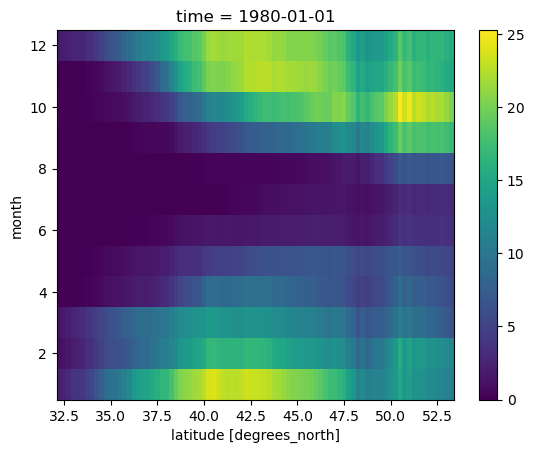

In [136]:
ARfreq_frac_zmean_bymonth_eragrid[:,7:-1].plot()

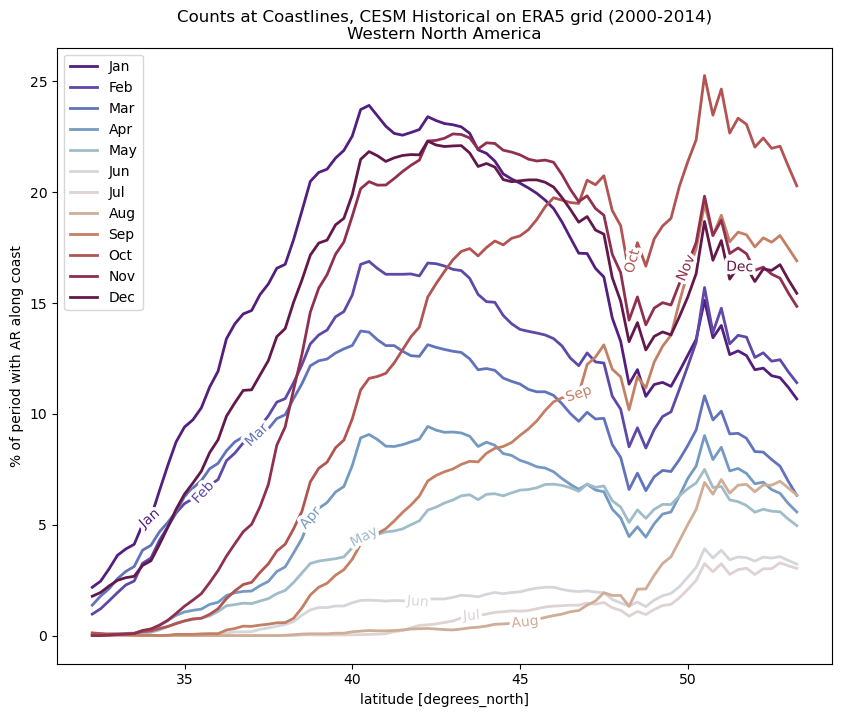

In [104]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

# Drop the lowest latitude (last index) due to remapping quirks
# Also drop highest several latitudes due to lack of data at those points - otherwise labelLines doesn't work
ax.plot(ARfreq_frac_zmean_bymonth_eragrid[:,7:-1].lat, ARfreq_frac_zmean_bymonth_eragrid[:,7:-1].transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, CESM Historical on ERA5 grid (2000-2014)\nWestern North America');

In [95]:
# ERA - CESM hist
ARfreq_frac_zmean_cesm_era_bymonth_diff = ARfreq_frac_zmean_era_bymonth - ARfreq_frac_zmean_bymonth_eragrid
ARfreq_frac_zmean_cesm_era_bymonth_diff

<xarray.DataArray (month: 12, lat: 93)> Size: 9kB
dask.array<sub, shape=(12, 93), dtype=float64, chunksize=(1, 93), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 372B 55.0 54.75 54.5 54.25 ... 32.75 32.5 32.25 32.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    time     datetime64[ns] 8B 1980-01-01

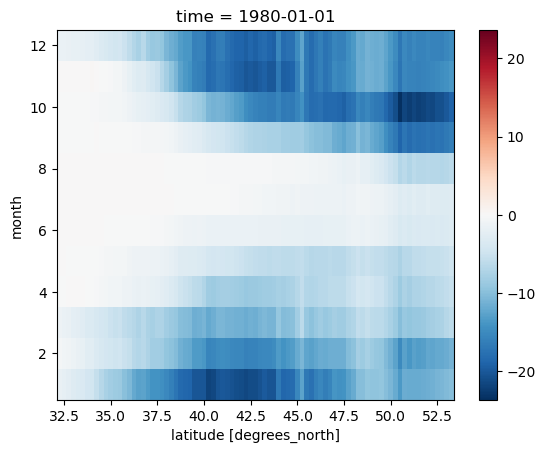

In [146]:
ARfreq_frac_zmean_cesm_era_bymonth_diff[:,7:-1].plot();

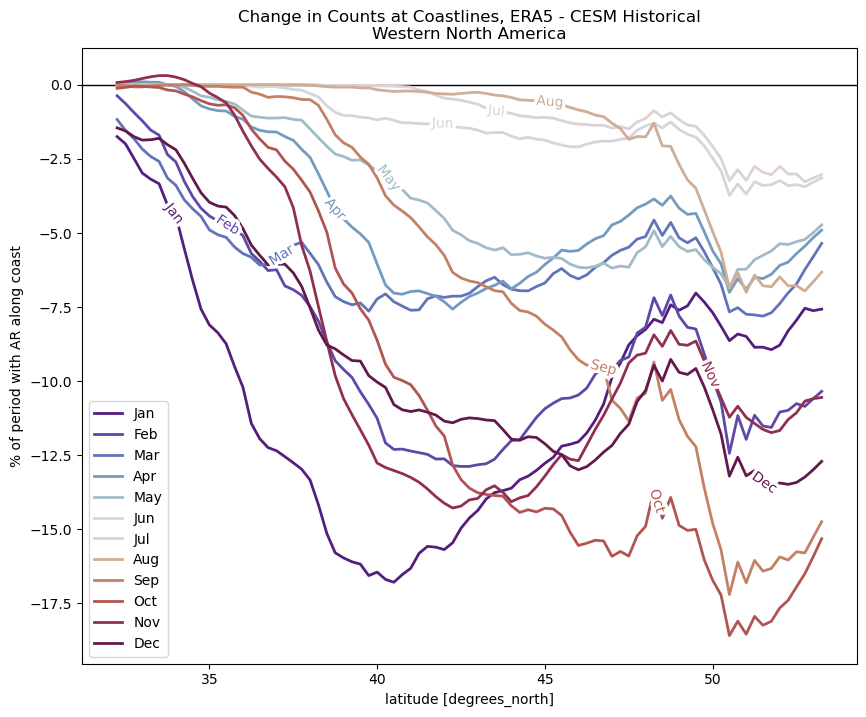

In [96]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))

#ax.plot(ARfreq_frac_zmean_cesm_era_bymonth_diff.lat, ARfreq_frac_zmean_cesm_era_bymonth_diff.transpose(), label=months, linewidth=2)
# drop the last latitude index due to boundary issues with remapping
# Also drop highest several latitudes due to lack of data at those points - otherwise labelLines doesn't work
ax.plot(ARfreq_frac_zmean_cesm_era_bymonth_diff[:,7:-1].lat, ARfreq_frac_zmean_cesm_era_bymonth_diff[:,7:-1].transpose(), label=months, linewidth=2)

labelLines(ax.get_lines(), zorder=2.5) # also doesn't work here

plt.axhline(y=0, color='k', linewidth=1, zorder=0)

plt.legend()

plt.xlabel('latitude [degrees_north]')
plt.ylabel('% of period with AR along coast')

plt.title('Change in Counts at Coastlines, ERA5 - CESM Historical\nWestern North America');

### All the plots!

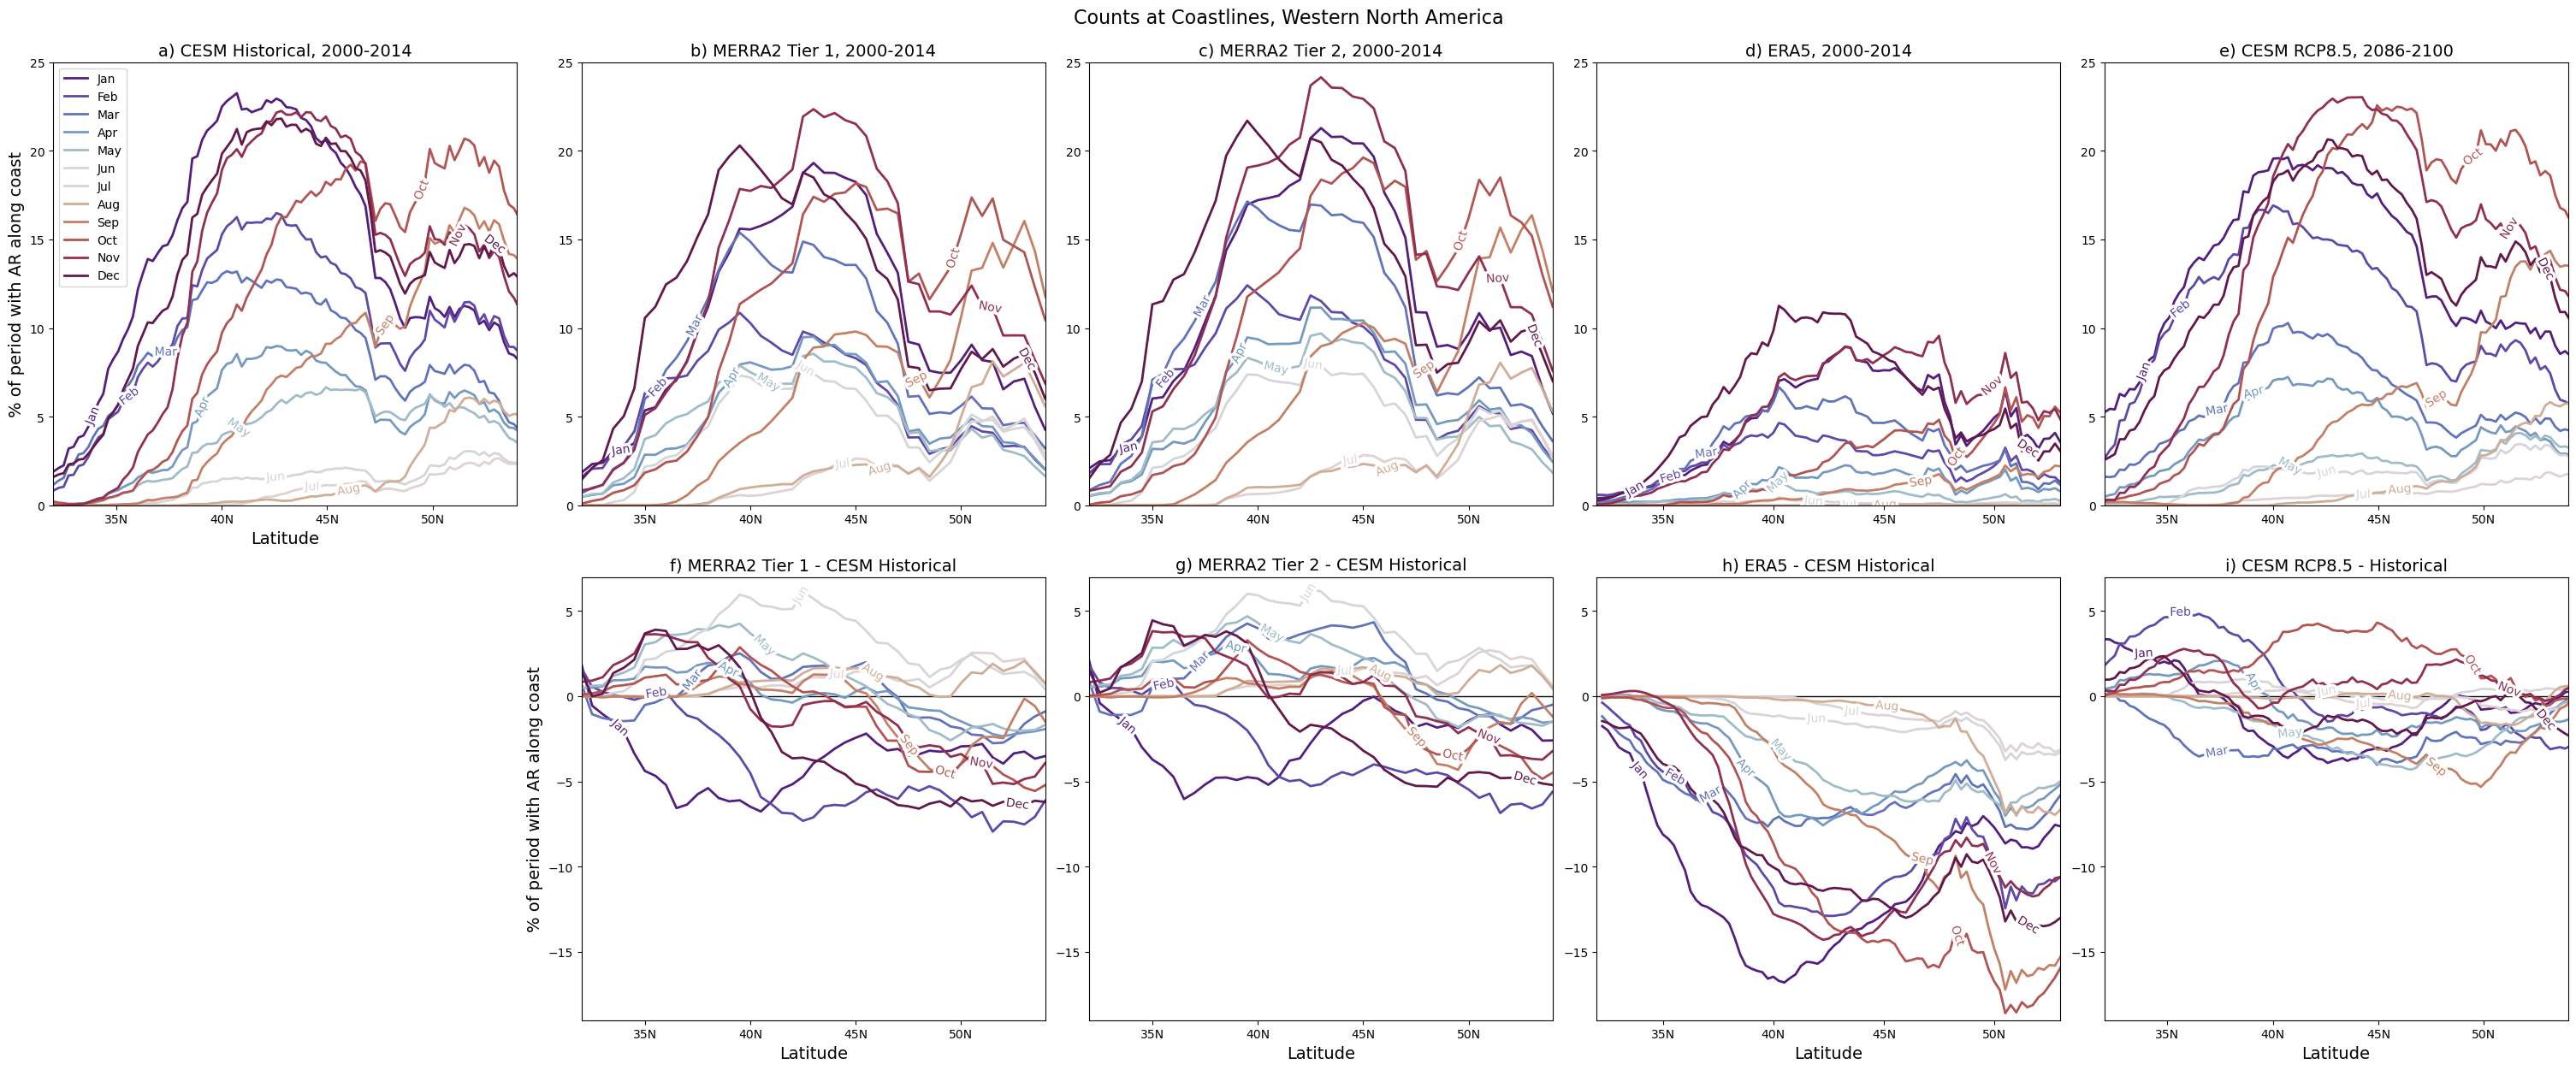

In [116]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper midleft', 'upper middle', 'upper midright', 'upper right'],
                               ['.', 'lower midleft', 'lower middle', 'lower midright', 'lower right']],
                              figsize=(30,12), layout="constrained")

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cm = plt.cm.twilight_shifted(np.linspace(0.1, 0.9, len(months)))

# CESM Historical
ax['upper left'].set_prop_cycle('color', list(cm))
ax['upper left'].plot(ARfreq_frac_zmean_bymonth.lat, ARfreq_frac_zmean_bymonth.transpose(), label=months, linewidth=2)
labelLines(ax['upper left'].get_lines(), zorder=2.5)
ax['upper left'].set_ylim([0,25])
ax['upper left'].set_ylabel('% of period with AR along coast', fontsize=14)
ax['upper left'].set_xlim(32,54)
ax['upper left'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['upper left'].set_xlabel('Latitude', fontsize=14)
ax['upper left'].set_title('a) CESM Historical, 2000-2014', fontsize=14) 
ax['upper left'].legend()

# MERRA2 Tier 1
ax['upper midleft'].set_prop_cycle('color', list(cm))
ax['upper midleft'].plot(ARfreq_frac_zmean_merra_bymonth.lat, ARfreq_frac_zmean_merra_bymonth.transpose(), label=months, linewidth=2)
labelLines(ax['upper midleft'].get_lines(), zorder=2.5)
ax['upper midleft'].set_ylim([0,25])
ax['upper midleft'].set_xlim(32,54)
ax['upper midleft'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['upper midleft'].set_title('b) MERRA2 Tier 1, 2000-2014', fontsize=14) 

# MERRA2 Tier 2
ax['upper middle'].set_prop_cycle('color', list(cm))
ax['upper middle'].plot(ARfreq_frac_zmean_merra_t2_bymonth.lat, ARfreq_frac_zmean_merra_t2_bymonth.transpose(), label=months, linewidth=2)
labelLines(ax['upper middle'].get_lines(), zorder=2.5)
ax['upper middle'].set_ylim([0,25])
ax['upper middle'].set_xlim(32,54)
ax['upper middle'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['upper middle'].set_title('c) MERRA2 Tier 2, 2000-2014', fontsize=14);

# ERA5
ax['upper midright'].set_prop_cycle('color', list(cm))
# drop highest several latitudes due to lack of data at those points - otherwise labelLines doesn't work
ax['upper midright'].plot(ARfreq_frac_zmean_era_bymonth[:,7:].lat, ARfreq_frac_zmean_era_bymonth[:,7:].transpose(), label=months, linewidth=2)
labelLines(ax['upper midright'].get_lines(), zorder=2.5)
ax['upper midright'].set_ylim([0,25])
ax['upper midright'].set_xlim(32,53)
ax['upper midright'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['upper midright'].set_title('d) ERA5, 2000-2014', fontsize=14);

# CESM RCP8.5
ax['upper right'].set_prop_cycle('color', list(cm))
ax['upper right'].plot(ARfreq_frac_zmean_rcp85_bymonth.lat, ARfreq_frac_zmean_rcp85_bymonth.transpose(), label=months, linewidth=2)
labelLines(ax['upper right'].get_lines(), zorder=2.5)
ax['upper right'].set_ylim([0,25])
ax['upper right'].set_xlim(32,54)
ax['upper right'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['upper right'].set_title('e) CESM RCP8.5, 2086-2100', fontsize=14) 

# MERRA - CESM Hist (remapped)
ax['lower midleft'].set_prop_cycle('color', list(cm))
# drop the last latitude index due to boundary issues with remapping
ax['lower midleft'].plot(ARfreq_frac_zmean_cesm_merra_bymonth_diff[:,:-1].lat, ARfreq_frac_zmean_cesm_merra_bymonth_diff[:,:-1].transpose(), label=months, linewidth=2)
labelLines(ax['lower midleft'].get_lines(), zorder=2.5)
ax['lower midleft'].axhline(y=0, color='k', linewidth=1, zorder=0)
ax['lower midleft'].set_ylim([-19,7])
ax['lower midleft'].set_xlim(32,54)
ax['lower midleft'].set_ylabel('% of period with AR along coast', fontsize=14)
ax['lower midleft'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['lower midleft'].set_xlabel('Latitude', fontsize=14)
ax['lower midleft'].set_title('f) MERRA2 Tier 1 - CESM Historical', fontsize=14) 

# MERRA Tier 2 - CESM Hist (remapped)
ax['lower middle'].set_prop_cycle('color', list(cm))
# drop the last latitude index due to boundary issues with remapping
ax['lower middle'].plot(ARfreq_frac_zmean_cesm_merra_t2_bymonth_diff[:,:-1].lat, ARfreq_frac_zmean_cesm_merra_t2_bymonth_diff[:,:-1].transpose(), label=months, linewidth=2)
labelLines(ax['lower middle'].get_lines(), zorder=2.5)
ax['lower middle'].axhline(y=0, color='k', linewidth=1, zorder=0)
ax['lower middle'].set_ylim([-19,7])
ax['lower middle'].set_xlim(32,54)
ax['lower middle'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['lower middle'].set_xlabel('Latitude', fontsize=14)
ax['lower middle'].set_title('g) MERRA2 Tier 2 - CESM Historical', fontsize=14);

# ERA - CESM Hist (remapped)
ax['lower midright'].set_prop_cycle('color', list(cm))
# drop the last latitude index due to boundary issues with remapping
# Also drop highest several latitudes due to lack of data at those points - otherwise labelLines doesn't work
ax['lower midright'].plot(ARfreq_frac_zmean_cesm_era_bymonth_diff[:,7:-1].lat, ARfreq_frac_zmean_cesm_era_bymonth_diff[:,7:-1].transpose(), label=months, linewidth=2)
labelLines(ax['lower midright'].get_lines(), zorder=2.5)
ax['lower midright'].axhline(y=0, color='k', linewidth=1, zorder=0)
ax['lower midright'].set_ylim([-19,7])
ax['lower midright'].set_xlim(32,53)
ax['lower midright'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['lower midright'].set_xlabel('Latitude', fontsize=14)
ax['lower midright'].set_title('h) ERA5 - CESM Historical', fontsize=14);

# CESM RCP - Historical
ax['lower right'].set_prop_cycle('color', list(cm))
ax['lower right'].plot(ARfreq_frac_zmean_cesm_bymonth_diff.lat, ARfreq_frac_zmean_cesm_bymonth_diff.transpose(), label=months, linewidth=2)
labelLines(ax['lower right'].get_lines(), zorder=2.5)
ax['lower right'].axhline(y=0, color='k', linewidth=1, zorder=0)
ax['lower right'].set_ylim([-19,7])
ax['lower right'].set_xlim(32,54)
ax['lower right'].set_xticks([35, 40, 45, 50], ['35N', '40N', '45N', '50N'])
ax['lower right'].set_xlabel('Latitude', fontsize=14)
ax['lower right'].set_title('i) CESM RCP8.5 - Historical', fontsize=14) 

#plt.legend()

fig.suptitle('Counts at Coastlines, Western North America', fontsize=16, y=1.03);

#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_bymonth_CESM_merra_era.png', bbox_inches='tight', dpi=300)

## Storm Duration
Using `artmip_stormdur_countsbylat_env.ncl` and `plot_artmip_countsbylat_dur.ncl`.

It looks like the ncl code relies on an external function(?) that I don't know how to parse:\
`external ar_stormcount_artmip "/fs/cgd/home0/shields/csm/ncl/wrappers/lib/ar_stormcount_artmip.so"`

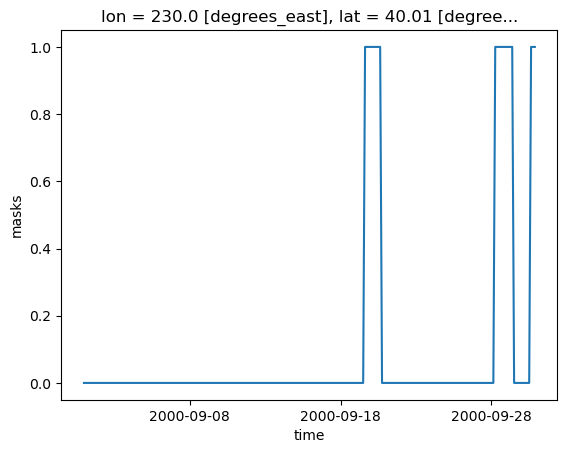

In [30]:
test_slice = AR.sel(lat=40, lon=230, method='nearest').sel(time=slice('2000-09-01','2000-09-30'))
test_slice.plot();

In [31]:
# I think what I need to do is look for consecutive 1's at each gridpoint over some time period
# Rutz et al. uses >= 12 hrs for AR event so that would be at least 5 consecutive 1's?
# Then keep track of the duration of those events so count the total # of 1's greater than or equal to 5 in a row
test_slice.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [32]:
# this is resampling to 12 hour periods and summing over those values
test_slice.resample(time='12h').sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 4, 0, 0, 3])

In [33]:
# this is looking at rolling 5-time point periods and summing them
# so once you get a "5" that means there has been an event
# and consecutive 5's tells you something about the event duration
# for example 5 consecutive 5's represents a 24-hr event, and 6 represents a 27-hr event
test_slice.rolling(time=5).sum().values

array([nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,  5.,  5.,
        5.,  5.,  4.,  3.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [96]:
client.close()
cluster.close()